In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')


C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# uncomment to disable GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

[]


In [3]:
def compare_to_ref(ref_traj, trajs, weights, *args, method = None, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
#     weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.02)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.002)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[p,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
#             if i * ncol + j in restrained_patches and method != 'unbiased':
#                 for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
#                     pf(ax[i,j],0, color='C3')
#                 ax[i,j].spines['bottom'].set_color('y')
#                 ax[i,j].spines['top'].set_color('y') 
#                 ax[i,j].spines['right'].set_color('y')
#                 ax[i,j].spines['left'].set_color('y')
#                 ax[i,j].spines['left'].set_linewidth(2)
#                 ax[i,j].spines['top'].set_linewidth(2)
#                 ax[i,j].spines['right'].set_linewidth(2)
#                 ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
    plt.tight_layout()


## Reference Model

In [4]:
# Loading trajectory
results=pd.read_csv('Resultscounty.txt',header=None,sep='\t')
results.columns=['ID','time','county','S','E','A','I','R','P','D']
# results=pd.merge(results,parameters,on='ID')
results.sort_values(['ID','time'],ascending=True,inplace=True)
dictionary=pd.read_csv('countydictionary.csv')
dictionary.columns=['COUNTY CODE','COUNTY NAME','county']
results=pd.merge(results,dictionary,on='county')
# results=resultspatch[['time','COUNTY NAME','S','E','A','I','R','P','D','beta','tauexposed','taupresymp','tauI','casefatalityrate','COUNTY CODE']]  
results=results[['ID','time','COUNTY NAME','S','E','A','I','R','P','D']]
results.loc[:,"S":"D"] = results.loc[:,"S":"D"].div(results.loc[:,"S":"D"].sum(axis =1), axis=0)
population =pd.read_csv('popCounty.txt',index_col=False,names=['ID','Population'],header=None,sep=' ')['Population'].tolist()
population_fraction = population/np.sum(population)
area =pd.read_csv('areaCounty.txt',index_col=False,names=['ID','Area'],header=None,sep=' ')['Area'].tolist()
# Getting number of patches
patches = np.unique(results['COUNTY NAME'].values)
M = len(patches)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


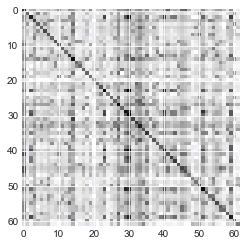

In [5]:
# load mobility matrix
networkCounty=pd.read_csv('networkCounty.txt',header=None,sep=' ')
networkCounty.columns=['ID','County','mobility_parameter']
# mobility_matrix = networkCounty.reset_index().groupby(['County'])['mobility_parameter'].apply(np.array).to_numpy()
# networkCounty = networkCounty[['ID','mobility_parameter']]
mobility_matrix = np.empty([0,M])
mobility_parameter_row = np.zeros(M)
for i,row in networkCounty.iterrows():
    mobility_parameter_row[networkCounty.loc[i, 'County']] = networkCounty.loc[i, 'mobility_parameter']
    if i < networkCounty.shape[0]-1:
        if networkCounty.loc[i+1, 'County'] == 0:
            mobility_matrix = np.append(mobility_matrix, [mobility_parameter_row], axis=0)
    #         print(mobility_parameter_row)
            mobility_parameter_row = np.zeros(M)
    else:
         mobility_matrix = np.append(mobility_matrix, [mobility_parameter_row], axis=0)

assert (np.shape(mobility_matrix)==(M,M))
mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
print (np.sum(mobility_matrix_norm, axis =1))
plt.imshow(np.log(mobility_matrix))

In [6]:
# Getting the time length
time_S = np.unique(results['time'].values)
Time_S = len(time_S)
# Getting number of trajectories
IDs = np.unique(results['ID'].values)
N = len(IDs)
np.set_printoptions(threshold=np.inf)
# Number of compartments
C = 7
ref_traj = np.empty((N, Time_S, M, C))
# start_time = 30
# end_time = 75
for n in IDs:
    for m, patch_name in enumerate(patches):
        ID = results.loc[results['ID'].isin([str(n)])]
        county = ID.loc[ID['COUNTY NAME'] == patch_name]
        traj_county = county[['S','E','A','I','R','P','D']].to_numpy()
        ref_traj[n,:,m,:] = traj_county
           
start_time = 0
end_time = 201  

Time = end_time - start_time
p = 0
# ref_traj = ref_traj[:, start_time:end_time,:,:]
## Combining P and D compartments into R
ref_traj[p,:,:,4] +=  ref_traj[p,:,:,5] + ref_traj[p,:,:,6]
ref_traj = ref_traj[p,:,:,:5]
# REF=ref_traj

# ref_traj = ref_traj[:,:,:]
ref_traj = ref_traj[np.newaxis,:,:,:]


Plotting 62 patches in a 7 x 9 grid


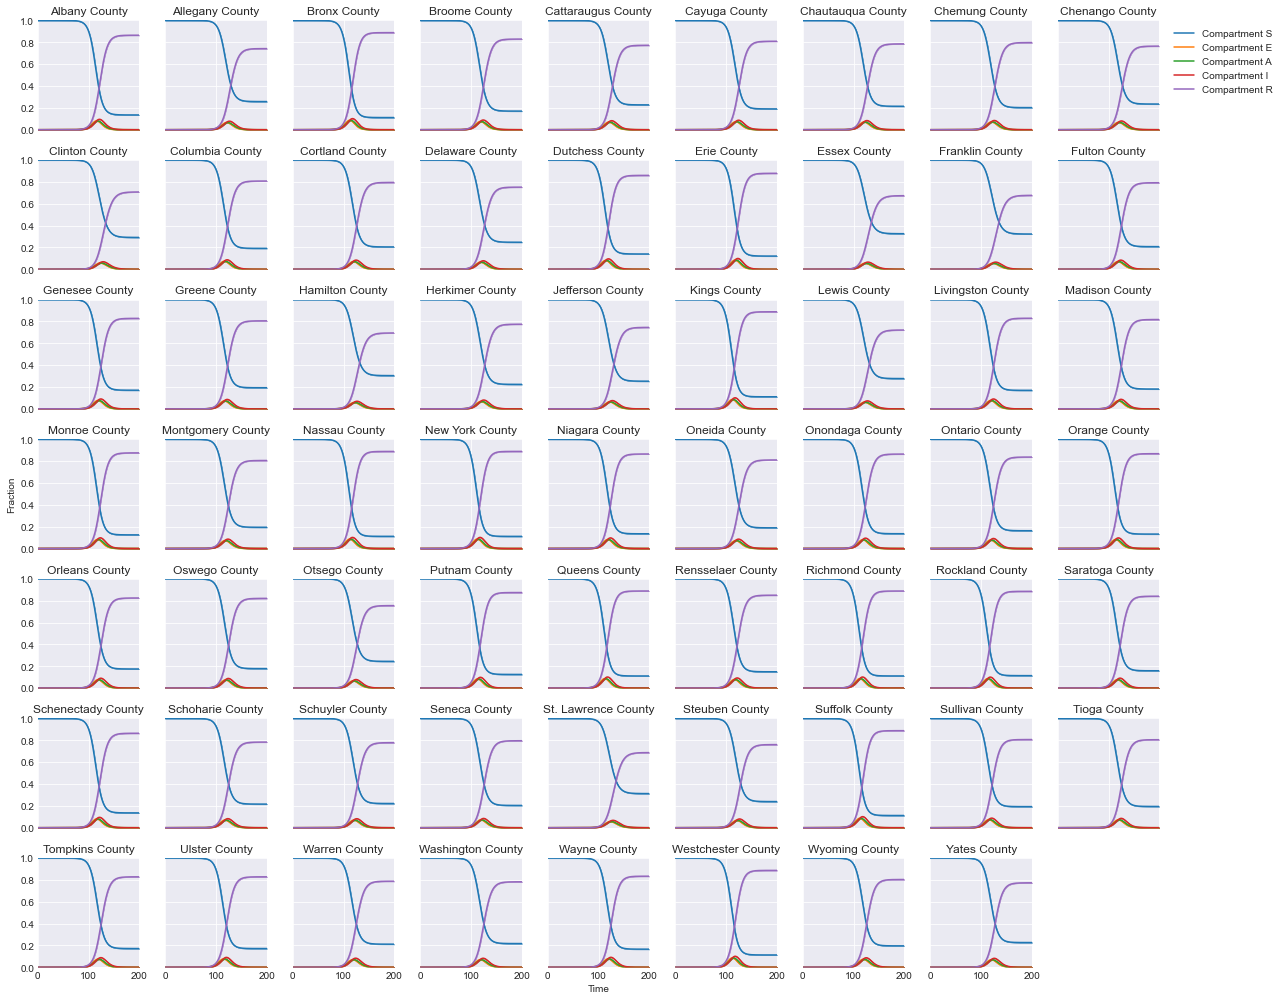

In [7]:
patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])
# plt.suptitle("Reference data", size=25, y=1.001)
# plt.tight_layout()
# plt.savefig('patch_quantile.png',dpi=400)

In [8]:
# ## make a maxentep traj to compare 
# # compartment parameters
# compartments = ['E', 'A', 'I', 'R']
# full_compartments = ['S'] + compartments
# infections_compartments = [1,2]
# C = len(compartments)
# tmat = maxentep.TransitionMatrix(compartments, [1,2])
eta = 1/2.6
alpha = 1/2.6
mu = 1/3.2
# tmat.add_transition('E', 'A', 1/eta, 0)
# tmat.add_transition('A', 'I', 1/alpha, 0)
# tmat.add_transition('I', 'R', 1/mu, 0)

# infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
# timesteps = 202
# model = maxentep.MetaModel(infect_fxn, timesteps, populations=np.array(population))

# # starting fractions probabilities
# start = np.zeros((M,C)) #anywhere
# # assume starting from Bronx county
# exposed_Bronx = 1/population[2]
# start[2,0] = exposed_Bronx
# # start[0,0] = 0.05
# beta = 0.04
# m_ref_traj = model(mobility_matrix_norm, tmat.value, start, beta)[0]
# ref_traj = m_ref_traj[np.newaxis,::,:]

# patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])

In [9]:
# compare_to_ref(ref_traj, m_ref_traj, weights=None, method='unbiased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)

In [10]:
# patch_quantile(m_ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])
# ref_traj = m_ref_traj
# total_pop = np.sum(population)
# R0 = 5
# t_max = np.log(total_pop)/mu/(R0-1)
# t_max

In [11]:
# Run this for creating frames for animations
import plotly.graph_objs as go
import plotly.figure_factory as ff 
process_traj = False
if process_traj == True:
    for t in range(T):
        infected_portion = [tf.round(ref_traj[0,t,i,3],2) for i in range(M)]
        zipcodes = dictionary['COUNTY CODE']
        fig = ff.create_choropleth(fips=zipcodes, 
                                   scope=['New York'],
                                   values=infected_portion,
                                   title='NY COVID-19 Infected Population Fraction by County',
                                   county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
                                   state_outline={'width': .5}
                                   )


        fig.update_layout(legend=dict(
            title='Infected Fraction',
            yanchor="top",
            y=0.95,
            xanchor="left",
            x=0.9,

        ))
        fig.add_annotation(dict(font=dict(color='black',size=30),
                                                x=0.4,
                                                y=0.12,
                                                showarrow=False,
                                                text="Day {}".format(t),
                                                textangle=0,
                                                xanchor='left',
                                                xref="paper",
                                                yref="paper"
                                                ))

        fig.layout.template = {'layout': {'font': {'family': 'Britannic Bold', 'size': 20}}}
        fig.write_image("NY_map//traj_" + str(t) +
                            ".png",width = 2048, height =1060)

# Run this for saving plots
if process_traj == True:
    for i in range(M):
        traj_quantile(ref_traj[:,:,i,:], names=['S','E','A','I','R','P','D'], add_legend=False, add_title = patches[i], plot_means=True)
        fig = plt.gcf()
        fig.set_size_inches(4, 4)
        #plt.savefig('{}.png'.format(patches[i]),dpi=400)
        plt.close()

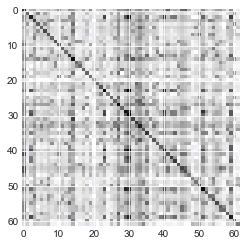

In [12]:
plt.imshow(np.log(mobility_matrix))

## Make restraints from reference trajectory

I R
Restraints are set in this time range: [75, 140]
136 0.026422962534773796 0.03085637969486953
101 0.031980205926788276 0.0467020185472364
73 0.0006733242385349254 0.01839374144447657
122 0.09151196587352736 0.10820363103515918
115 0.09637822465367399 0.08867143531319847
115 0.34603295934844913 0.3200498262251844
73 0.0013550406143372769 0.0
94 0.02740697310929859 0.05991237471669553
101 0.07128345925512376 0.06908959139617728
129 0.7298949692972538 0.7233747406442433
122 0.07278034074032105 0.06920698245763234
115 0.047059422651597405 0.05678426766022026
87 0.0012414090025358426 0.0
80 0.00044101910548119606 0.0
108 0.02265484785996922 0.024067355320379867
136 0.56935541273225 0.5884851684975723
108 0.04967701746164506 0.05179844084358379
87 0.002423264320407499 0.0
101 0.018782674427973822 0.004310042194098912
94 0.006813703935548796 0.0027820618553980377
115 0.06001234579038983 0.04981995343909079
122 0.0816586365722826 0.08345106002196874
80 0.00068925567409149 0.0
87 0.00190398

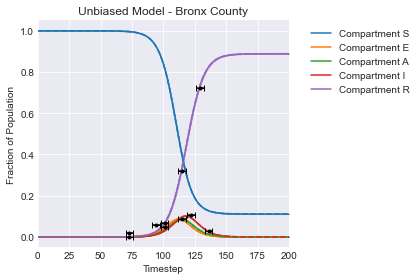

I R
[ 2 50 17]
2


In [80]:
compartments = ['E','A','I','R']
infections_compartments = [1,2]
full_compartments = ['S'] + compartments
npoints = 5
prior = maxentep.EmptyPrior()
# prior = maxentep.Laplace(0.1)
# p = 0

# restrained_patches = np.random.randint(M, size=number_of_restraint_patches)
number_of_restrained_patches = 3 
restrained_compartments = [3,4] #(infected patch and recovered)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
restrained_compartments_names = " ".join(restrained_compartments_names)
print (restrained_compartments_names)
number_of_restrained_compartments = len(restrained_compartments) 

restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)

restrained_patch = restrained_patches[0]
# def compartment_restrainer(number_of_restrained_patches,number_of_restrained_compartments,npoints,ref_traj,prior,noise=0,time_average=7):
#     if number_of_restrained_patches > M:
#         raise ValueError(
#             "Oops! Number of patches to be restrained exceeeds the total number of patches.")
# #     p = 0  # picking one trajectory from the parameter set (pick the first 1)
#     # example if number_of_restraint_patches = 2 : (recovered and infected patch)
#     restraints =[] 
#     plot_fxns_list = []
#     for i in range(number_of_restrained_patches):
#         plot_fxns = []
#         for j in range(number_of_restrained_compartments):
#             res, plfxn = maxentep.traj_to_restraints(ref_traj[p,:80,:,:], [restrained_patches[i],restrained_compartments[j]], npoints, prior, noise,time_average)
#             restraints += res 
#             plot_fxns += plfxn
#         plot_fxns_list.append(plot_fxns)
#     return restraints, plot_fxns_list


restraints, plot_fxns_list = maxentep.compartment_restrainer(restrained_patches,
                                                    restrained_compartments,ref_traj, prior,npoints=npoints,
                                                    noise=0.01,start_time=75, end_time=140)
maxentep.traj_quantile(ref_traj[:,:,restrained_patch,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[p,:,restrained_patch,:], linestyle='--')
plt.title('Unbiased Model - {}'.format(patches[restrained_patch]))
for i,pf in enumerate(plot_fxns_list[0]):
    pf(plt.gca(), 0)
plt.tight_layout()
plt.savefig('unbiased.png',dpi=200)
# plt.ylim(0,0.2)
# plt.xlim(0,75)
plt.show()
print (restrained_compartments_names)
print(restrained_patches)
print(restrained_patch)

## Restraining a sample SEAIRPD to reference

In [21]:
print(max(1/np.array(population)))
print(np.mean(1/np.array(population)))
print(np.var(1/np.array(population)))

0.00021222410865874363
1.6059567615649856e-05
7.469191736144403e-10


In [22]:
# compartment parameters
compartments = ['E','A','I','R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 3, 1)
tmat.add_transition('A', 'I', 3, 1)
tmat.add_transition('I', 'R', 4, 1)

print(tmat.value)
hyper_pram = maxentep.ParameterHypers()
hyper_pram.beta_low = 0.005
# hyper_pram.beta_low = 0.001
# hyper_pram.beta_high = 0.04
hyper_pram.beta_high = 0.06
hyper_pram.beta_var = 0.02
# hyper_pram.start_high = 2e-4
hyper_pram.start_high = 5e-3
hyper_pram.R_var = 10
hyper_pram.beta_start = 0.03
hyper_pram.start_mean = 1e-5
hyper_pram.start_scale = 1e-9

start_logits = np.zeros((M))
param_model = maxentep.MetaParameterJoint(start_logits, mobility_matrix , tmat, name='unbiased_model', hypers = hyper_pram)

[[0.66666667 0.33333333 0.         0.        ]
 [0.         0.66666667 0.33333333 0.        ]
 [0.         0.         0.75       0.25      ]
 [0.         0.         0.         1.        ]]


In [23]:
intial_exposed_guess = 1/np.array(population)
v = param_model.sample(10)
start_dist = v[2]
# start_dist
# mask = tf.greater(start_dist, 0)
# start_exposed_dist = tf.boolean_mask(start_dist, mask).numpy()
# tf.reduce_mean(start_exposed_dist)
start_dist.shape

TensorShape([10, 62, 4])

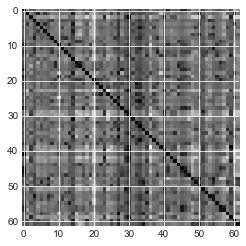

In [24]:
# Making sure our sample for mobility network is reasonable
R = v[0]
plt.imshow(np.log(R[0]))

In [25]:
def get_dist(prior_prams):
    R_dist = []
    T_dist = []
    start_dist = []
    beta_dist = []
    for i in range(len(prior_prams)):
        param_batch = prior_prams[i]
        R_dist.append(param_batch[0])
        T_dist.append(param_batch[1])
        start_dist.append(param_batch[2])
        beta_dist.append(param_batch[3])
    R_dist = tf.concat(R_dist, axis = 0)
    T_dist = tf.concat(T_dist, axis = 0)
    start_dist = tf.concat(start_dist, axis = 0)
    beta_dist = tf.concat(beta_dist, axis = 0)
    # get eta
    E_A = 1/T_dist[:, compartments.index('E'), compartments.index('A')].numpy()
    # get alpha
    A_I = 1/T_dist[:, compartments.index('A'), compartments.index('I')].numpy()
    # get mu
    I_R = 1/T_dist[:, compartments.index('I'), compartments.index('R')].numpy()
    # Getting starting exposed fraction 
    mask = tf.greater(start_dist, 0)
    start_exposed_dist = tf.boolean_mask(start_dist, mask).numpy()
    return [R_dist, E_A, A_I, I_R, start_exposed_dist, beta_dist]
    
def plot_dist(R_dist, E_A, A_I, I_R, start_exposed_dist, beta_dist, name='prior'):
    import seaborn as sns
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,6), dpi=200)
    fig.suptitle(f'Parameter {name} distributions', fontsize=20,y=1.00)
    sns.distplot(x=beta_dist, ax = axs[0,0], axlabel='Beta')
    sns.distplot(x=start_exposed_dist, ax = axs[0,1], axlabel='Exposed start fraction')
    sns.distplot(x=R_dist, ax = axs[0,2], axlabel='Mobility matrix')
    sns.distplot(x=E_A, ax = axs[1,0], axlabel=r'$\eta^{-1}$ : E->A (days)')
    sns.distplot(x=A_I, ax = axs[1,1], axlabel=r'$\alpha ^{-1}$ : A->I (days)')
    sns.distplot(x=I_R, ax = axs[1,2], axlabel=r'$\mu^{-1}$ : I->R (days)')

In [26]:
intial_exposed_guess = 1/np.array(population)
import tqdm
N = 8192
batches = 8
total_batches= N*batches
outs = []
infect = maxentep.contact_infection_func(infections_compartments, area = area)
# model = maxentep.MetaModel(infect, Time,populations = np.round(population))
model = maxentep.MetaModel(infect, Time, populations = population)
prior_prams = []
for b in tqdm.tqdm(range(batches)):
    ps = param_model.sample(N)
#     R_dist= ps[0]
#     output_list = []
#     for i in range(R_dist.shape[0]):
#         R_dist_d = mobility_matrix
#         norm_R_dist_d = R_dist_d/ tf.math.reduce_sum(R_dist_d, axis = 1, keepdims=True)
#         output_list.append(norm_R_dist_d)
#     outputs = tf.stack(output_list)
#     ps[0] = outputs
    start_dist = ps[2]
    new_start_dist = np.zeros_like(start_dist)
    start_dist_list = []
    for i in range(start_dist.shape[0]):
        index = tf.where(start_dist[i]>0)[0][0].numpy()
        new_start_dist[i,index,0] = intial_exposed_guess[index]
    start_dist_list.append(new_start_dist)
    outputs = tf.stack(start_dist_list, axis =0)
    ps[2] = tf.squeeze(outputs)
    prior_prams.append(ps)
    outs.append(model(*ps))
trajs = np.concatenate(outs, axis=0)
# trajs = trajs[:,start_time:end_time,:,:]
print(trajs.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [21:58<00:00, 164.87s/it]


(65536, 201, 62, 5)


## Visualizing the unbiased traj

Plotting 62 patches in a 7 x 9 grid


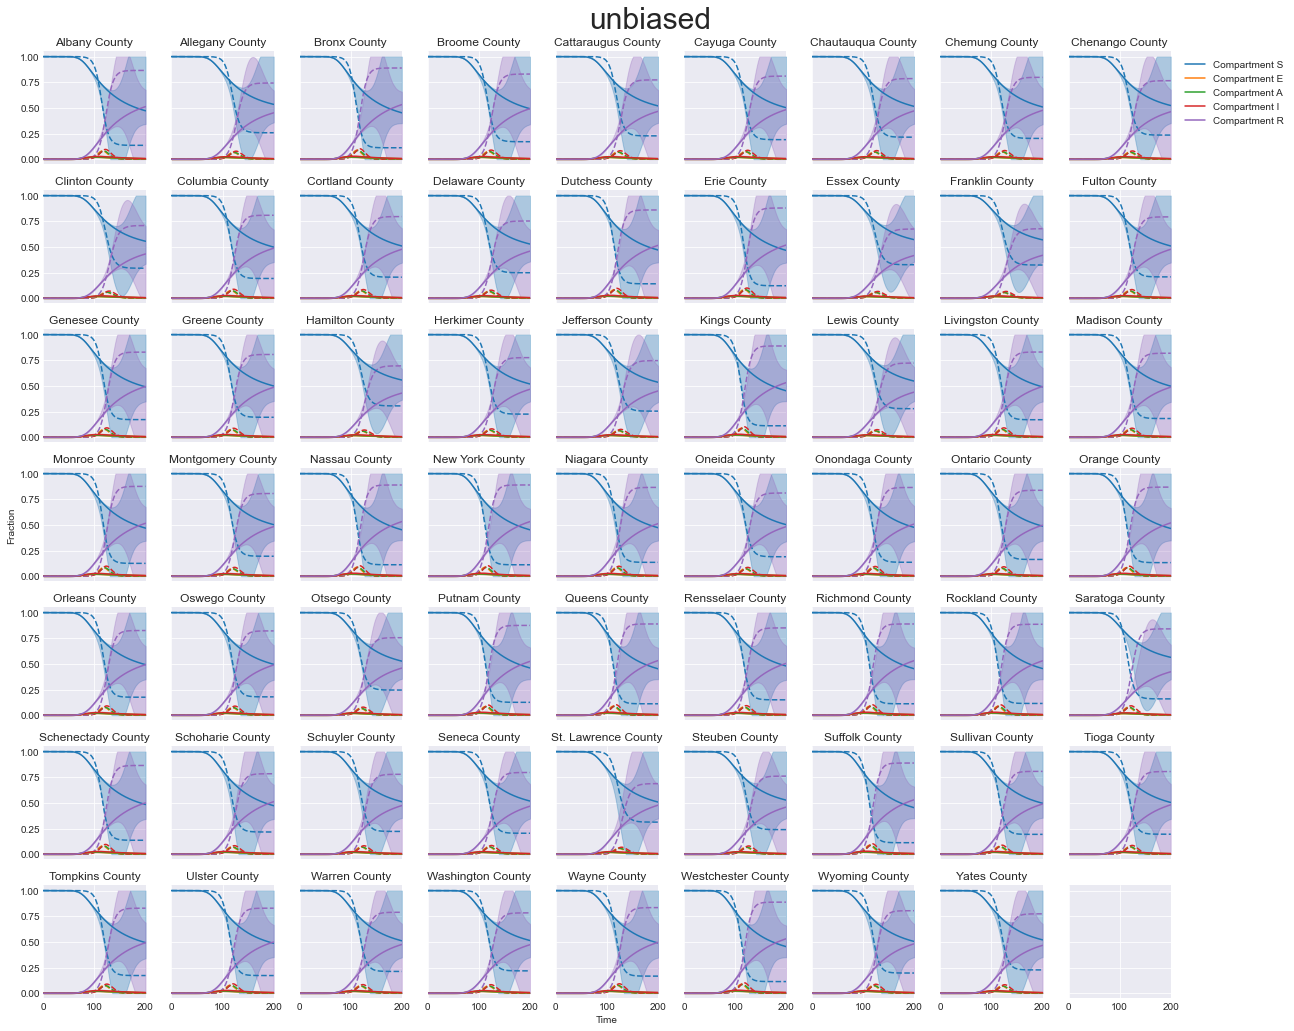

In [27]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
compare_to_ref(ref_traj,trajs, weights=None, method='unbiased', patch_names = patches, 
               figsize=(18, 14), alpha=0.3, names=full_compartments)

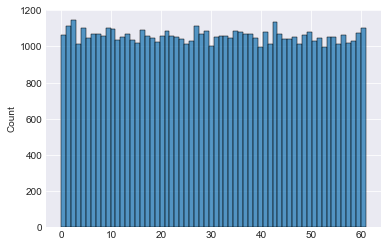

In [28]:
prior_exposed_patch = maxentep.exposed_finder(trajs)
sns.histplot(x=prior_exposed_patch, label='Prior', color='C0',bins=M)

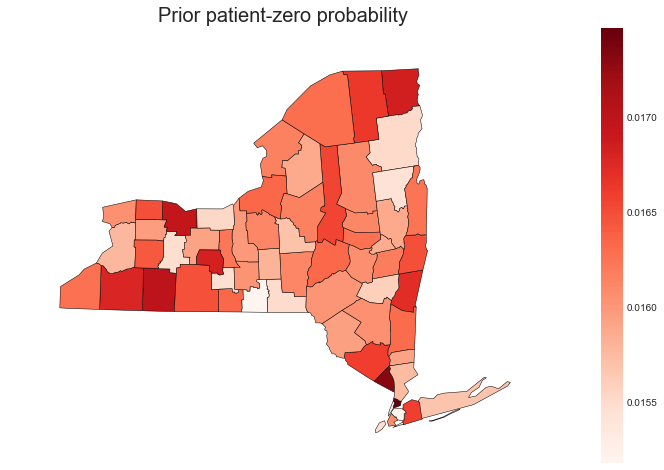

In [29]:
maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability',
                fontsize=20, choropleth=True,
       geojson='counties_ny.geojson')

In [30]:
prior_param_dist = get_dist(prior_prams)

In [31]:
# plot_dist(*prior_param_dist)

In [32]:
# ref_traj = tf.squeeze(ref_traj)
# if tf.rank(ref_traj).numpy() != 4:
#     ref_traj = ref_traj[tf.newaxis, ...]
# ref_traj.shape

In [33]:

# print (restrained_compartments_names)
# npoints =4
# prior = maxentep.EmptyPrior()
# cutting the ref_traj in half
# restraints_R, plot_fxn_R = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [restrained_patch,4], npoints, prior, noise=0,time_average=7)
#restraints_E, plot_fxn_E = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,1], npoints, prior, noise=0,time_average=7)
#restraints_A, plot_fxn_A = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,2], npoints, prior, noise=0,time_average=7)
# restraints_I, plot_fxn_I = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [restrained_patch,3], npoints, prior, noise=0,time_average=7)
#restraints_P, plot_fxn_P = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,5], npoints, prior, noise=0,time_average=7)
#restraints_D, plot_fxn_D = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,6], npoints, prior, noise=0,time_average=7)
#restraints = restraints_R + restraints_E + restraints_A + restraints_I + restraints_P + restraints_D
#plot_fxns = plot_fxn_R + plot_fxn_E + plot_fxn_A + plot_fxn_I + plot_fxn_P + plot_fxn_D
# restraints = restraints_I + restraints_R
# plot_fxns = plot_fxn_I + plot_fxn_R


In [105]:
me_model = maxentep.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')

In [106]:
# class CustomCallback(tf.keras.callbacks.Callback):
#     def __init__(self):
#         self. i = 0
#     def on_epoch_begin(self, epoch, logs=None):
#         self.i += 1
#         return self.i


In [107]:
me_history = me_model.fit(trajs, batch_size=N//4,epochs=1000)#, callbacks=[CustomCallback()])

Epoch 1/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0042 - weight-entropy: 7.1197
Epoch 2/1000
32/32 [==============================] - 0s 1ms/step - loss: 8.3504e-04 - weight-entropy: 6.5413
Epoch 3/1000
32/32 [==============================] - 0s 1ms/step - loss: 6.7954e-04 - weight-entropy: 6.3773
Epoch 4/1000
32/32 [==============================] - 0s 1ms/step - loss: 6.4487e-04 - weight-entropy: 6.2908
Epoch 5/1000
32/32 [==============================] - 0s 1ms/step - loss: 5.9657e-04 - weight-entropy: 6.2207
Epoch 6/1000
32/32 [==============================] - 0s 1ms/step - loss: 5.9662e-04 - weight-entropy: 6.1827
Epoch 7/1000
32/32 [==============================] - 0s 1ms/step - loss: 5.7679e-04 - weight-entropy: 6.1604
Epoch 8/1000
32/32 [==============================] - 0s 1ms/step - loss: 5.5915e-04 - weight-entropy: 6.1336
Epoch 9/1000
32/32 [==============================] - 0s 1ms/step - loss: 5.5709e-04 - weight-entropy: 6.1294
Epoch 10/1000


32/32 [==============================] - 0s 1ms/step - loss: 1.8795e-04 - weight-entropy: 5.4306
Epoch 75/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.8925e-04 - weight-entropy: 5.4278
Epoch 76/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.9278e-04 - weight-entropy: 5.4059
Epoch 77/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.9317e-04 - weight-entropy: 5.4047
Epoch 78/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.8931e-04 - weight-entropy: 5.3920
Epoch 79/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.8862e-04 - weight-entropy: 5.3806
Epoch 80/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.9064e-04 - weight-entropy: 5.3707
Epoch 81/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.8285e-04 - weight-entropy: 5.3659
Epoch 82/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.9133e-04 - weight-entropy: 5.3562
Epoch 83/1000
3

32/32 [==============================] - 0s 1ms/step - loss: 1.4878e-04 - weight-entropy: 4.9699
Epoch 148/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.4721e-04 - weight-entropy: 4.9521
Epoch 149/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.5384e-04 - weight-entropy: 4.9574
Epoch 150/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.4956e-04 - weight-entropy: 4.9518
Epoch 151/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.5407e-04 - weight-entropy: 4.9309
Epoch 152/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.4528e-04 - weight-entropy: 4.9343
Epoch 153/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.5355e-04 - weight-entropy: 4.9310
Epoch 154/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.4007e-04 - weight-entropy: 4.9296
Epoch 155/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.5022e-04 - weight-entropy: 4.9200
Epoch 1

32/32 [==============================] - 0s 1ms/step - loss: 1.3968e-04 - weight-entropy: 4.6537
Epoch 221/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3163e-04 - weight-entropy: 4.6505
Epoch 222/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.4447e-04 - weight-entropy: 4.6449
Epoch 223/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3220e-04 - weight-entropy: 4.6333
Epoch 224/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3491e-04 - weight-entropy: 4.6301
Epoch 225/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3281e-04 - weight-entropy: 4.6370
Epoch 226/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.4224e-04 - weight-entropy: 4.6182
Epoch 227/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3626e-04 - weight-entropy: 4.6339
Epoch 228/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3574e-04 - weight-entropy: 4.6267
Epoch 2

32/32 [==============================] - 0s 1ms/step - loss: 1.3039e-04 - weight-entropy: 4.4666
Epoch 294/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2905e-04 - weight-entropy: 4.4676
Epoch 295/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3343e-04 - weight-entropy: 4.4704
Epoch 296/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2862e-04 - weight-entropy: 4.4659
Epoch 297/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3842e-04 - weight-entropy: 4.4716
Epoch 298/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3218e-04 - weight-entropy: 4.4616
Epoch 299/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3458e-04 - weight-entropy: 4.4586
Epoch 300/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3232e-04 - weight-entropy: 4.4603
Epoch 301/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3966e-04 - weight-entropy: 4.4681
Epoch 3

32/32 [==============================] - 0s 2ms/step - loss: 1.2896e-04 - weight-entropy: 4.3778
Epoch 367/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3523e-04 - weight-entropy: 4.3723
Epoch 368/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.2982e-04 - weight-entropy: 4.3827
Epoch 369/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.3372e-04 - weight-entropy: 4.3848
Epoch 370/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.2700e-04 - weight-entropy: 4.3697
Epoch 371/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.3853e-04 - weight-entropy: 4.3792
Epoch 372/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.3504e-04 - weight-entropy: 4.3771
Epoch 373/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.3964e-04 - weight-entropy: 4.3789
Epoch 374/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3671e-04 - weight-entropy: 4.3702
Epoch 3

32/32 [==============================] - 0s 1ms/step - loss: 1.3539e-04 - weight-entropy: 4.3244
Epoch 440/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.4099e-04 - weight-entropy: 4.3233
Epoch 441/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3703e-04 - weight-entropy: 4.3199
Epoch 442/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.2661e-04 - weight-entropy: 4.3135
Epoch 443/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3266e-04 - weight-entropy: 4.3216
Epoch 444/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.4032e-04 - weight-entropy: 4.3280
Epoch 445/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.3666e-04 - weight-entropy: 4.3205
Epoch 446/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.3104e-04 - weight-entropy: 4.3294
Epoch 447/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.3015e-04 - weight-entropy: 4.3169
Epoch 4

32/32 [==============================] - 0s 1ms/step - loss: 1.3296e-04 - weight-entropy: 4.2799
Epoch 513/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2557e-04 - weight-entropy: 4.2803
Epoch 514/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3012e-04 - weight-entropy: 4.2771
Epoch 515/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.4563e-04 - weight-entropy: 4.2754
Epoch 516/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3196e-04 - weight-entropy: 4.2967
Epoch 517/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3361e-04 - weight-entropy: 4.2910
Epoch 518/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.4729e-04 - weight-entropy: 4.2855
Epoch 519/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3724e-04 - weight-entropy: 4.2858
Epoch 520/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2928e-04 - weight-entropy: 4.2774
Epoch 5

32/32 [==============================] - 0s 1ms/step - loss: 1.3042e-04 - weight-entropy: 4.2473
Epoch 586/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.3244e-04 - weight-entropy: 4.2580
Epoch 587/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3003e-04 - weight-entropy: 4.2578
Epoch 588/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2904e-04 - weight-entropy: 4.2584
Epoch 589/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3800e-04 - weight-entropy: 4.2658
Epoch 590/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.3434e-04 - weight-entropy: 4.2560
Epoch 591/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2519e-04 - weight-entropy: 4.2570
Epoch 592/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3668e-04 - weight-entropy: 4.2614
Epoch 593/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3283e-04 - weight-entropy: 4.2573
Epoch 5

32/32 [==============================] - 0s 1ms/step - loss: 1.2908e-04 - weight-entropy: 4.2369
Epoch 659/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.2868e-04 - weight-entropy: 4.2416
Epoch 660/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.2894e-04 - weight-entropy: 4.2431
Epoch 661/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.2692e-04 - weight-entropy: 4.2314
Epoch 662/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.3616e-04 - weight-entropy: 4.2263
Epoch 663/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.3106e-04 - weight-entropy: 4.2388
Epoch 664/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.2528e-04 - weight-entropy: 4.2365
Epoch 665/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3088e-04 - weight-entropy: 4.2392
Epoch 666/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2893e-04 - weight-entropy: 4.2402
Epoch 6

32/32 [==============================] - 0s 1ms/step - loss: 1.2938e-04 - weight-entropy: 4.2137
Epoch 732/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2773e-04 - weight-entropy: 4.1981
Epoch 733/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3183e-04 - weight-entropy: 4.2136
Epoch 734/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3329e-04 - weight-entropy: 4.2130
Epoch 735/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2718e-04 - weight-entropy: 4.2068
Epoch 736/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2668e-04 - weight-entropy: 4.2083
Epoch 737/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2811e-04 - weight-entropy: 4.2070
Epoch 738/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3620e-04 - weight-entropy: 4.2173
Epoch 739/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2529e-04 - weight-entropy: 4.2198
Epoch 7

32/32 [==============================] - 0s 1ms/step - loss: 1.2815e-04 - weight-entropy: 4.2040
Epoch 805/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2719e-04 - weight-entropy: 4.2030
Epoch 806/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3748e-04 - weight-entropy: 4.2156
Epoch 807/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3370e-04 - weight-entropy: 4.2076
Epoch 808/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2779e-04 - weight-entropy: 4.2083
Epoch 809/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2406e-04 - weight-entropy: 4.2051
Epoch 810/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3518e-04 - weight-entropy: 4.2058
Epoch 811/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3025e-04 - weight-entropy: 4.2031
Epoch 812/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3165e-04 - weight-entropy: 4.2052
Epoch 8

32/32 [==============================] - 0s 1ms/step - loss: 1.2724e-04 - weight-entropy: 4.1891
Epoch 878/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3445e-04 - weight-entropy: 4.1957
Epoch 879/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2919e-04 - weight-entropy: 4.1900
Epoch 880/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2864e-04 - weight-entropy: 4.1890
Epoch 881/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.4102e-04 - weight-entropy: 4.1912
Epoch 882/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3457e-04 - weight-entropy: 4.1884
Epoch 883/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3394e-04 - weight-entropy: 4.1855
Epoch 884/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2485e-04 - weight-entropy: 4.1854
Epoch 885/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3446e-04 - weight-entropy: 4.1896
Epoch 8

32/32 [==============================] - 0s 1ms/step - loss: 1.4053e-04 - weight-entropy: 4.1566
Epoch 951/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3038e-04 - weight-entropy: 4.1703
Epoch 952/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2702e-04 - weight-entropy: 4.1602
Epoch 953/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3000e-04 - weight-entropy: 4.1621
Epoch 954/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3738e-04 - weight-entropy: 4.1609
Epoch 955/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2941e-04 - weight-entropy: 4.1608
Epoch 956/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2542e-04 - weight-entropy: 4.1599
Epoch 957/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2930e-04 - weight-entropy: 4.1486
Epoch 958/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.3182e-04 - weight-entropy: 4.1572
Epoch 9

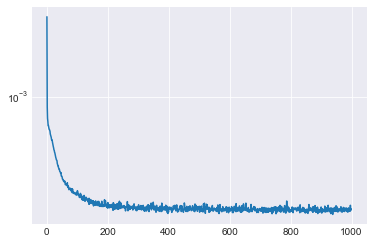

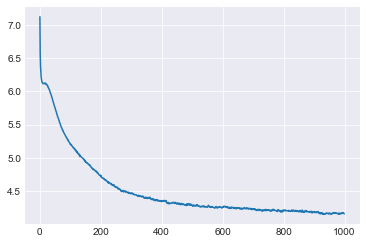

In [108]:
plt.plot(me_history.history['loss'])
plt.yscale('log')
plt.show()
plt.plot(me_history.history['weight-entropy'])
plt.show()

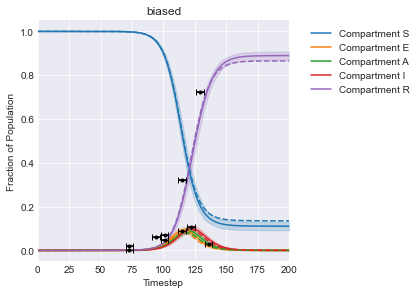

In [109]:
patch_number = 0
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights,alpha=0.2, names=full_compartments)
plt.plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(plt, me_model.lambdas[i], color='k')
plt.tight_layout()
# plt.ylim(0,0.2)
# plt.xlim(0,75)
plt.title('biased')
plt.show()

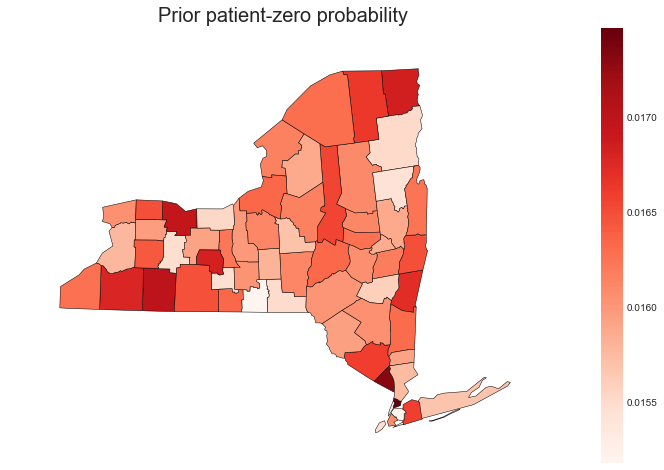

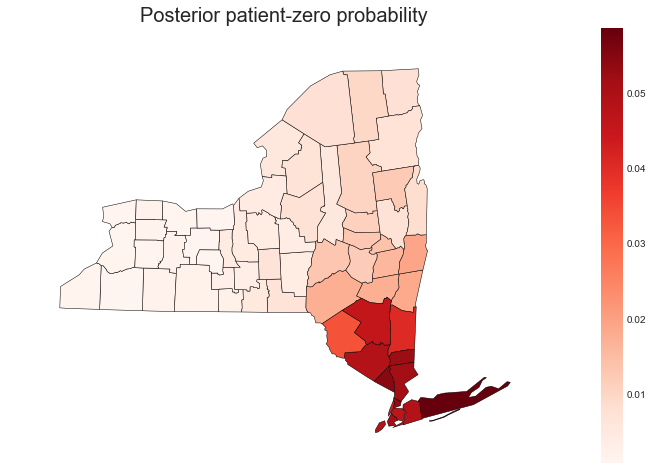

In [110]:
me_w = me_model.traj_weights
prior_exposed_patch = maxentep.exposed_finder(trajs)
posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)
maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability', fontsize=20, choropleth=True,
       geojson='counties_ny.geojson')
maxentep.p0_map(prior_exposed_patch, M, weights = me_w, title = 'Posterior patient-zero probability', patch_names=patches, fontsize=20
      , choropleth=True, geojson='counties_ny.geojson')

In [111]:
sorted(zip(prior_exposed_patch, patches), reverse=True)[:5]

[(61, 'Putnam County'),
 (61, 'Clinton County'),
 (61, 'Bronx County'),
 (60, 'Kings County'),
 (59, 'Genesee County')]

In [112]:
sorted(zip(posterior_exposed_prob, patches), reverse=True)[:5]

[(0.0586937674645646, 'Suffolk County'),
 (0.05443641322962075, 'Rockland County'),
 (0.05340461499124991, 'Bronx County'),
 (0.05242298137268866, 'Putnam County'),
 (0.051602942947807824, 'Westchester County')]

## Algorithm 2

In [113]:
fit_param_model = maxentep.MetaParameterJoint(start_logits, mobility_matrix , tmat, name='unbiased_model',hypers = hyper_pram )
fit_param_model.compile(tf.optimizers.SGD(1))

hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model, reweight=False)
hme_model.compile(tf.keras.optimizers.SGD(learning_rate=1), 'mean_squared_error')

In [114]:
hme_history = hme_model.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=3, param_epochs=50, batch_size=N, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 997us/step - loss: 0.0311 - weight-entropy: 9.0109
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0255 - weight-entropy: 9.0047
Epoch 3/100
1/1 [==============================] - 0s 998us/step - loss: 0.0227 - weight-entropy: 8.9936
Epoch 4/100
1/1 [==============================] - 0s 999us/step - loss: 0.0213 - weight-entropy: 8.9826
Epoch 5/100
1/1 [==============================] - 0s 996us/step - loss: 0.0204 - weight-entropy: 8.9729
Epoch 6/100
1/1 [==============================] - 0s 997us/step - loss: 0.0199 - weight-entropy: 8.9647
Epoch 7/100
1/1 [==============================] - 0s 996us/step - loss: 0.0196 - weight-entropy: 8.9578
Epoch 8/100
1/1 [==============================] - 0s 997us/step - loss: 0.0194 - weight-entropy: 8.9520
Epoch 9/100
1/1 [==============================] - 0s 998us/step - loss: 0.0192 - weight-entropy: 8.9471
Epoch 10/100
1/1 [==============================] - 0s 99

1/1 [==============================] - 0s 2ms/step - loss: 0.0175 - weight-entropy: 8.9167
Epoch 73/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0174 - weight-entropy: 8.9166
Epoch 74/100
1/1 [==============================] - 0s 998us/step - loss: 0.0174 - weight-entropy: 8.9165
Epoch 75/100
1/1 [==============================] - 0s 998us/step - loss: 0.0174 - weight-entropy: 8.9163
Epoch 76/100
1/1 [==============================] - 0s 998us/step - loss: 0.0174 - weight-entropy: 8.9162
Epoch 77/100
1/1 [==============================] - 0s 998us/step - loss: 0.0173 - weight-entropy: 8.9160
Epoch 78/100
1/1 [==============================] - 0s 998us/step - loss: 0.0173 - weight-entropy: 8.9159
Epoch 79/100
1/1 [==============================] - 0s 997us/step - loss: 0.0173 - weight-entropy: 8.9157
Epoch 80/100
1/1 [==============================] - 0s 997us/step - loss: 0.0173 - weight-entropy: 8.9156
Epoch 81/100
1/1 [==============================] - 0s 988us/st

256/256 [==============================] - 1s 4ms/step - loss: 0.5911 - R-dist-dist_loss: 0.6429 - T-dist-dist_loss: -3.4874e-04 - rho-dist-dist_loss: -0.0396 - beta-dist_loss: -0.0119
Epoch 28/50
256/256 [==============================] - 1s 4ms/step - loss: 0.5911 - R-dist-dist_loss: 0.6429 - T-dist-dist_loss: -3.4875e-04 - rho-dist-dist_loss: -0.0396 - beta-dist_loss: -0.0119
Epoch 29/50
256/256 [==============================] - 1s 3ms/step - loss: 0.5911 - R-dist-dist_loss: 0.6429 - T-dist-dist_loss: -3.4876e-04 - rho-dist-dist_loss: -0.0396 - beta-dist_loss: -0.0119
Epoch 30/50
256/256 [==============================] - 1s 3ms/step - loss: 0.5911 - R-dist-dist_loss: 0.6429 - T-dist-dist_loss: -3.4877e-04 - rho-dist-dist_loss: -0.0396 - beta-dist_loss: -0.0119
Epoch 31/50
256/256 [==============================] - 1s 3ms/step - loss: 0.5911 - R-dist-dist_loss: 0.6429 - T-dist-dist_loss: -3.4878e-04 - rho-dist-dist_loss: -0.0396 - beta-dist_loss: -0.0119
Epoch 32/50
256/256 [======

1/1 [==============================] - 0s 1000us/step - loss: 0.0165 - weight-entropy: 8.9816
Epoch 35/100
1/1 [==============================] - 0s 997us/step - loss: 0.0165 - weight-entropy: 8.9812
Epoch 36/100
1/1 [==============================] - 0s 994us/step - loss: 0.0165 - weight-entropy: 8.9809
Epoch 37/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0165 - weight-entropy: 8.9806
Epoch 38/100
1/1 [==============================] - 0s 998us/step - loss: 0.0164 - weight-entropy: 8.9803
Epoch 39/100
1/1 [==============================] - 0s 996us/step - loss: 0.0164 - weight-entropy: 8.9800
Epoch 40/100
1/1 [==============================] - 0s 997us/step - loss: 0.0164 - weight-entropy: 8.9796
Epoch 41/100
1/1 [==============================] - 0s 998us/step - loss: 0.0164 - weight-entropy: 8.9793
Epoch 42/100
1/1 [==============================] - 0s 994us/step - loss: 0.0164 - weight-entropy: 8.9789
Epoch 43/100
1/1 [==============================] - 0s 997us

256/256 [==============================] - 1s 3ms/step - loss: 0.5910 - R-dist-dist_loss: 0.6429 - T-dist-dist_loss: -3.5070e-04 - rho-dist-dist_loss: -0.0396 - beta-dist_loss: -0.0119
Epoch 7/50
256/256 [==============================] - 1s 3ms/step - loss: 0.5910 - R-dist-dist_loss: 0.6429 - T-dist-dist_loss: -3.5071e-04 - rho-dist-dist_loss: -0.0396 - beta-dist_loss: -0.0119
Epoch 8/50
256/256 [==============================] - 1s 3ms/step - loss: 0.5910 - R-dist-dist_loss: 0.6429 - T-dist-dist_loss: -3.5072e-04 - rho-dist-dist_loss: -0.0396 - beta-dist_loss: -0.0119
Epoch 9/50
256/256 [==============================] - 1s 3ms/step - loss: 0.5910 - R-dist-dist_loss: 0.6429 - T-dist-dist_loss: -3.5072e-04 - rho-dist-dist_loss: -0.0396 - beta-dist_loss: -0.0119
Epoch 10/50
256/256 [==============================] - 1s 3ms/step - loss: 0.5910 - R-dist-dist_loss: 0.6429 - T-dist-dist_loss: -3.5073e-04 - rho-dist-dist_loss: -0.0396 - beta-dist_loss: -0.0119
Epoch 11/50
256/256 [=========

Epoch 46/50
256/256 [==============================] - 1s 3ms/step - loss: 0.5910 - R-dist-dist_loss: 0.6429 - T-dist-dist_loss: -3.5081e-04 - rho-dist-dist_loss: -0.0396 - beta-dist_loss: -0.0119
Epoch 47/50
256/256 [==============================] - 1s 3ms/step - loss: 0.5910 - R-dist-dist_loss: 0.6429 - T-dist-dist_loss: -3.5081e-04 - rho-dist-dist_loss: -0.0396 - beta-dist_loss: -0.0119
Epoch 48/50
256/256 [==============================] - 1s 3ms/step - loss: 0.5910 - R-dist-dist_loss: 0.6429 - T-dist-dist_loss: -3.5081e-04 - rho-dist-dist_loss: -0.0396 - beta-dist_loss: -0.0119
Epoch 49/50
256/256 [==============================] - 1s 3ms/step - loss: 0.5910 - R-dist-dist_loss: 0.6429 - T-dist-dist_loss: -3.5081e-04 - rho-dist-dist_loss: -0.0396 - beta-dist_loss: -0.0119
Epoch 50/50
256/256 [==============================] - 1s 3ms/step - loss: 0.5910 - R-dist-dist_loss: 0.6429 - T-dist-dist_loss: -3.5082e-04 - rho-dist-dist_loss: -0.0396 - beta-dist_loss: -0.0119
Epoch 1/100
8/8

8/8 [==============================] - 0s 2ms/step - loss: 0.0094 - weight-entropy: 8.6832
Epoch 71/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0093 - weight-entropy: 8.6765
Epoch 72/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0092 - weight-entropy: 8.6701
Epoch 73/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0091 - weight-entropy: 8.6633
Epoch 74/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0091 - weight-entropy: 8.6566
Epoch 75/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0090 - weight-entropy: 8.6500
Epoch 76/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0089 - weight-entropy: 8.6438
Epoch 77/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0088 - weight-entropy: 8.6373
Epoch 78/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0088 - weight-entropy: 8.6306
Epoch 79/100
8/8 [==============================] - 0s 3ms/step - loss: 0.008

In [115]:
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error') 
# hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), loss=ref_traj_loss)
hme_final_history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=N, epochs=500)

Epoch 1/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0195 - weight-entropy: 9.0043
Epoch 2/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0185 - weight-entropy: 9.0012
Epoch 3/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0173 - weight-entropy: 8.9934
Epoch 4/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0161 - weight-entropy: 8.9735
Epoch 5/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0148 - weight-entropy: 8.9455
Epoch 6/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0136 - weight-entropy: 8.9070
Epoch 7/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0124 - weight-entropy: 8.8587
Epoch 8/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0112 - weight-entropy: 8.8017
Epoch 9/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0102 - weight-entropy: 8.7396
Epoch 10/500
8/8 [==============================] - 0s 3ms/step - loss: 0

8/8 [==============================] - 0s 3ms/step - loss: 0.0017 - weight-entropy: 7.0087
Epoch 74/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0017 - weight-entropy: 6.9974
Epoch 75/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0017 - weight-entropy: 6.9844
Epoch 76/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 6.9736
Epoch 77/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 6.9582
Epoch 78/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 6.9424
Epoch 79/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 6.9309
Epoch 80/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 6.9179
Epoch 81/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 6.9075
Epoch 82/500
8/8 [==============================] - 0s 2ms/step - loss: 0.001

8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.2037
Epoch 152/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.2068
Epoch 153/500
8/8 [==============================] - 0s 2ms/step - loss: 9.9920e-04 - weight-entropy: 6.1920
Epoch 154/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.1901
Epoch 155/500
8/8 [==============================] - 0s 2ms/step - loss: 9.9506e-04 - weight-entropy: 6.1771
Epoch 156/500
8/8 [==============================] - 0s 2ms/step - loss: 9.9953e-04 - weight-entropy: 6.1788
Epoch 157/500
8/8 [==============================] - 0s 2ms/step - loss: 9.9871e-04 - weight-entropy: 6.1780
Epoch 158/500
8/8 [==============================] - 0s 2ms/step - loss: 9.8735e-04 - weight-entropy: 6.1597
Epoch 159/500
8/8 [==============================] - 0s 2ms/step - loss: 9.9124e-04 - weight-entropy: 6.1474
Epoch 160/500
8/8 [==========================

8/8 [==============================] - 0s 2ms/step - loss: 8.2309e-04 - weight-entropy: 5.7352
Epoch 227/500
8/8 [==============================] - 0s 2ms/step - loss: 8.2517e-04 - weight-entropy: 5.7354
Epoch 228/500
8/8 [==============================] - 0s 2ms/step - loss: 8.3215e-04 - weight-entropy: 5.7328
Epoch 229/500
8/8 [==============================] - 0s 2ms/step - loss: 8.2167e-04 - weight-entropy: 5.7284
Epoch 230/500
8/8 [==============================] - 0s 2ms/step - loss: 8.2708e-04 - weight-entropy: 5.7302
Epoch 231/500
8/8 [==============================] - 0s 2ms/step - loss: 8.4125e-04 - weight-entropy: 5.7498
Epoch 232/500
8/8 [==============================] - 0s 2ms/step - loss: 8.1641e-04 - weight-entropy: 5.7094
Epoch 233/500
8/8 [==============================] - 0s 2ms/step - loss: 8.1445e-04 - weight-entropy: 5.7044
Epoch 234/500
8/8 [==============================] - 0s 2ms/step - loss: 8.4337e-04 - weight-entropy: 5.6979
Epoch 235/500
8/8 [==============

8/8 [==============================] - 0s 2ms/step - loss: 7.3370e-04 - weight-entropy: 5.4323
Epoch 302/500
8/8 [==============================] - 0s 2ms/step - loss: 7.4643e-04 - weight-entropy: 5.4366
Epoch 303/500
8/8 [==============================] - 0s 2ms/step - loss: 7.3284e-04 - weight-entropy: 5.4302
Epoch 304/500
8/8 [==============================] - 0s 2ms/step - loss: 7.2184e-04 - weight-entropy: 5.4283
Epoch 305/500
8/8 [==============================] - 0s 2ms/step - loss: 7.2196e-04 - weight-entropy: 5.4327
Epoch 306/500
8/8 [==============================] - 0s 2ms/step - loss: 7.3037e-04 - weight-entropy: 5.4111
Epoch 307/500
8/8 [==============================] - 0s 3ms/step - loss: 7.1777e-04 - weight-entropy: 5.4129
Epoch 308/500
8/8 [==============================] - 0s 4ms/step - loss: 7.1276e-04 - weight-entropy: 5.4045
Epoch 309/500
8/8 [==============================] - 0s 3ms/step - loss: 7.5280e-04 - weight-entropy: 5.4505
Epoch 310/500
8/8 [==============

8/8 [==============================] - 0s 2ms/step - loss: 6.7790e-04 - weight-entropy: 5.2618
Epoch 377/500
8/8 [==============================] - 0s 3ms/step - loss: 6.6101e-04 - weight-entropy: 5.2410
Epoch 378/500
8/8 [==============================] - 0s 2ms/step - loss: 6.5782e-04 - weight-entropy: 5.2544
Epoch 379/500
8/8 [==============================] - 0s 2ms/step - loss: 6.6300e-04 - weight-entropy: 5.2469
Epoch 380/500
8/8 [==============================] - 0s 2ms/step - loss: 6.6639e-04 - weight-entropy: 5.2383
Epoch 381/500
8/8 [==============================] - 0s 2ms/step - loss: 6.9364e-04 - weight-entropy: 5.2675
Epoch 382/500
8/8 [==============================] - 0s 2ms/step - loss: 6.7291e-04 - weight-entropy: 5.2692
Epoch 383/500
8/8 [==============================] - 0s 2ms/step - loss: 6.7358e-04 - weight-entropy: 5.2429
Epoch 384/500
8/8 [==============================] - 0s 2ms/step - loss: 6.8213e-04 - weight-entropy: 5.2631
Epoch 385/500
8/8 [==============

8/8 [==============================] - 0s 3ms/step - loss: 6.2565e-04 - weight-entropy: 5.1576
Epoch 452/500
8/8 [==============================] - 0s 3ms/step - loss: 6.5639e-04 - weight-entropy: 5.1837
Epoch 453/500
8/8 [==============================] - 0s 2ms/step - loss: 6.1776e-04 - weight-entropy: 5.1311
Epoch 454/500
8/8 [==============================] - 0s 2ms/step - loss: 6.3341e-04 - weight-entropy: 5.1387
Epoch 455/500
8/8 [==============================] - 0s 3ms/step - loss: 6.6482e-04 - weight-entropy: 5.1759
Epoch 456/500
8/8 [==============================] - 0s 2ms/step - loss: 6.4436e-04 - weight-entropy: 5.1940
Epoch 457/500
8/8 [==============================] - 0s 2ms/step - loss: 6.4245e-04 - weight-entropy: 5.1629
Epoch 458/500
8/8 [==============================] - 0s 2ms/step - loss: 6.1753e-04 - weight-entropy: 5.1335
Epoch 459/500
8/8 [==============================] - 0s 3ms/step - loss: 6.4831e-04 - weight-entropy: 5.1960
Epoch 460/500
8/8 [==============

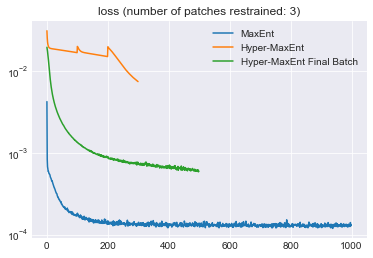

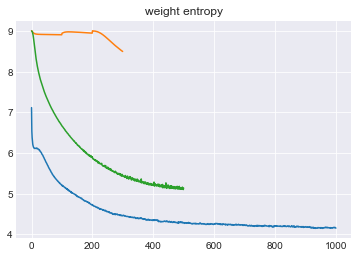

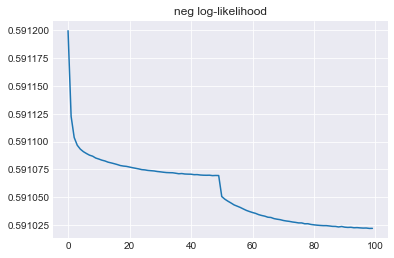

In [116]:
plt.plot(me_history.history['loss'],label='MaxEnt')
plt.plot(hme_history.history['loss'],label='Hyper-MaxEnt')
plt.plot(hme_final_history.history['loss'],label='Hyper-MaxEnt Final Batch')
plt.title('loss (number of patches restrained: {})'.format(len(restrained_patches)))
plt.yscale('log')
plt.legend()
plt.savefig('loss_{}_restraints'.format(len(restrained_patches)),dpi= 300)
plt.show()

plt.plot(me_history.history['weight-entropy'])
plt.plot(hme_history.history['weight-entropy'])
plt.plot(hme_final_history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(hme_history.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

# plt.plot(hme_history.history['loss-from-ref'])
# plt.show()

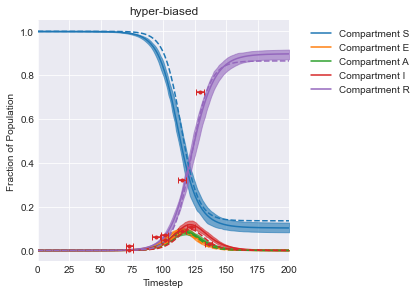

In [117]:
patch_number = 0
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments)
plt.plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(plt, hme_model.lambdas[i], color='C3')
plt.tight_layout()
# plt.ylim(0,0.2)
# plt.xlim(0,75)
plt.title('hyper-biased')
plt.show()


## Direct Regression of Model

In [118]:
T = tmat.value
start = np.zeros((M, C))
start[0,1] = 1e-6
infect = maxentep.ContactInfectionLayer(hyper_pram.beta_start, infections_compartments, area=area)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, mobility_matrix, T, infect, Time, agreement, populations=population)

In [119]:
rmodel.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(150)
rtraj = rmodel.get_traj()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

150/150 [==============================] - 15s 102ms/step - loss: nan - output_2_loss: nan


## Visualizing results

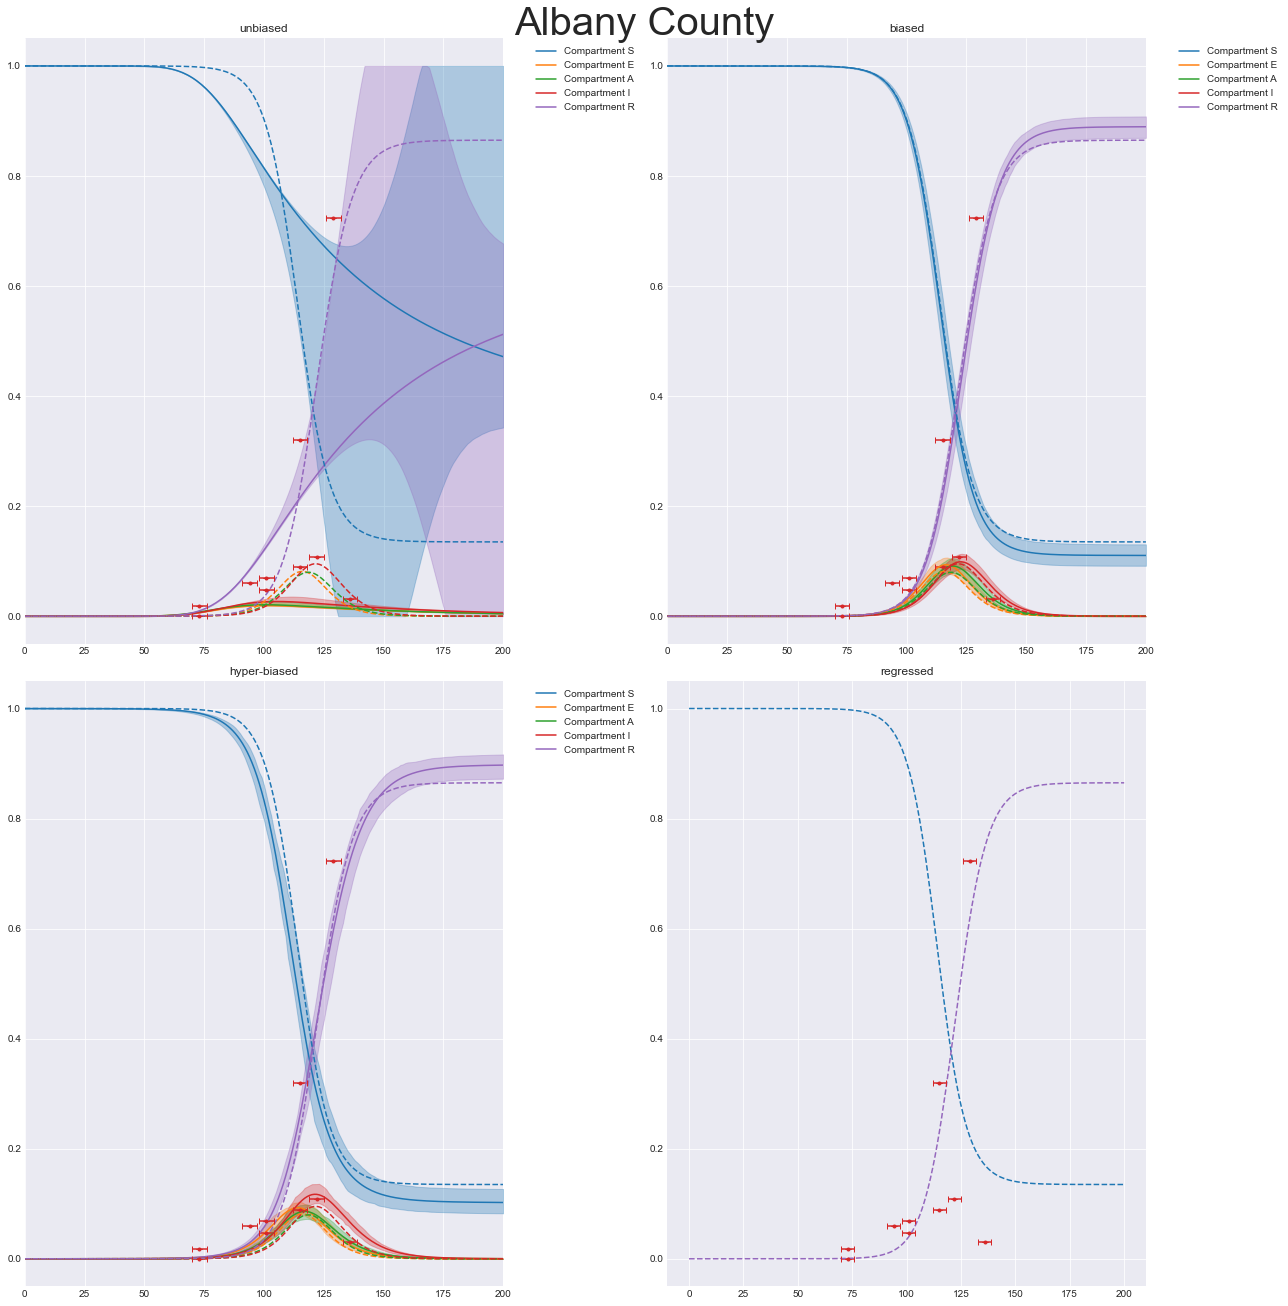

In [120]:
patch_number = 0
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0],alpha = 0.3)
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')

for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[0,0], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments,alpha = 0.3, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], alpha = 0.3,weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,1], 1, color='C3')

    
plt.tight_layout()
# plt.savefig('compare_Albany.png', dpi = 300)
plt.show()
plt.close()

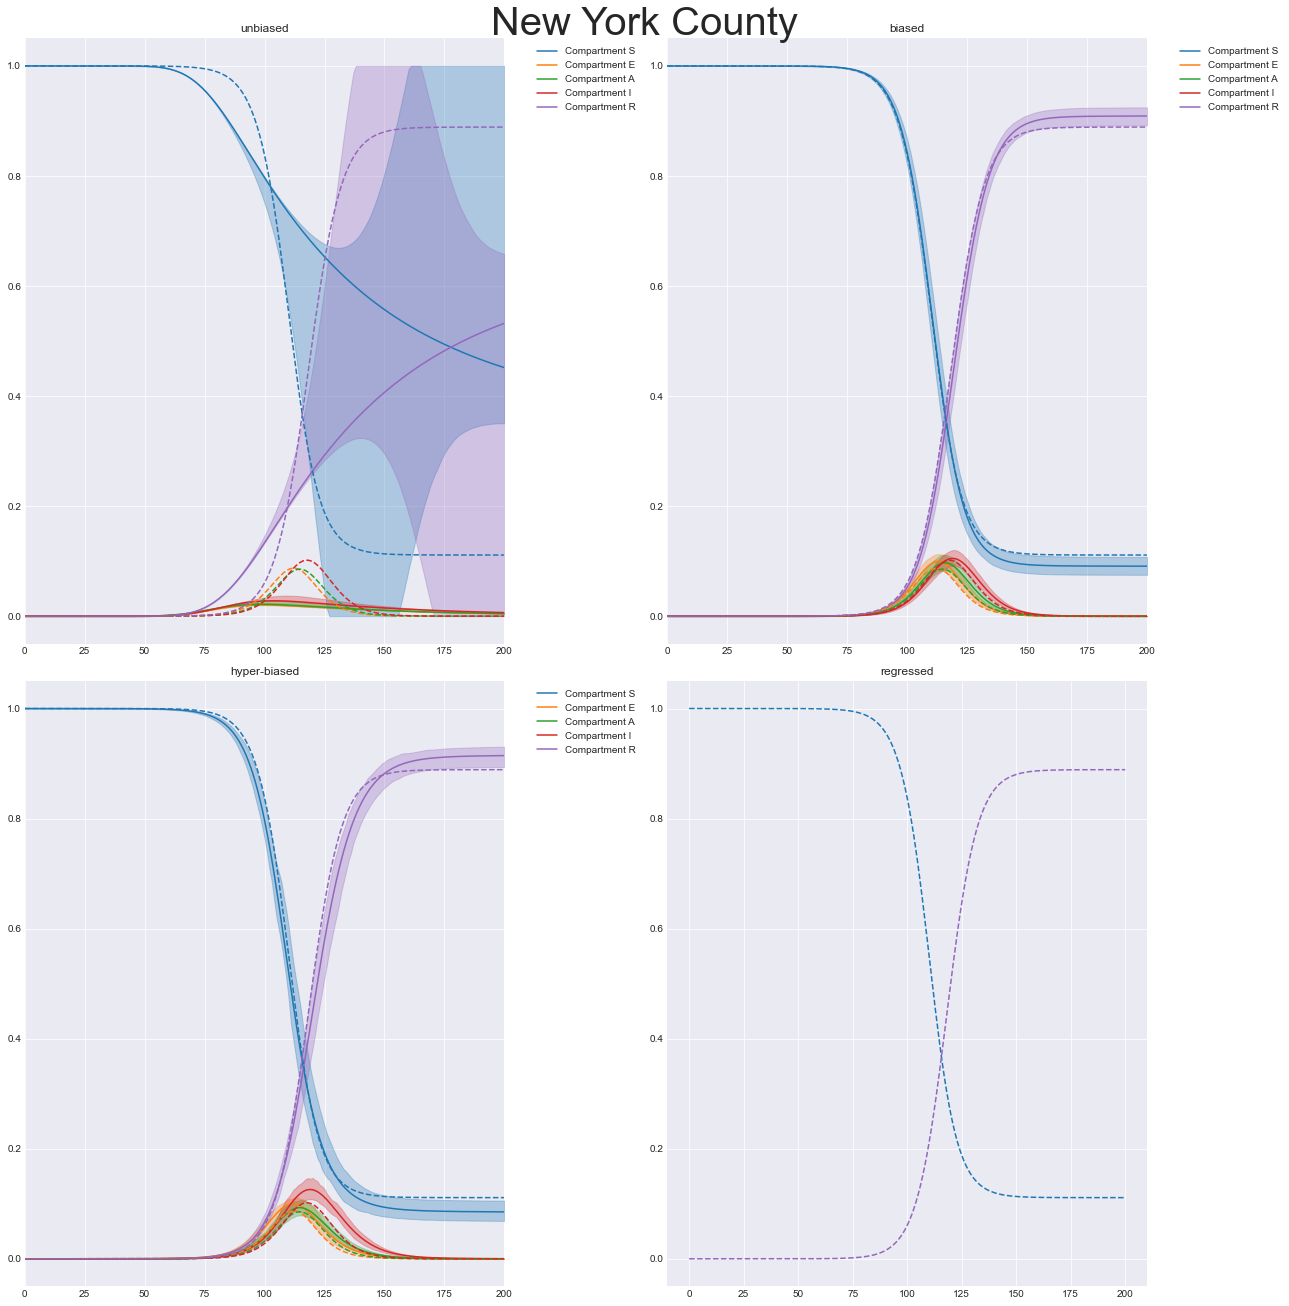

In [121]:
patch_number = 30
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0],alpha = 0.3)
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# ax[0,0].tick_params(color='green', labelcolor='green')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[0,0], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, alpha = 0.3,names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[0,1], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, alpha = 0.3,names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[1,0], hme_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[1,1], 1, color='C3')

plt.tight_layout()
# plt.savefig('compare_NY.png', dpi = 300)
plt.show()
plt.close()

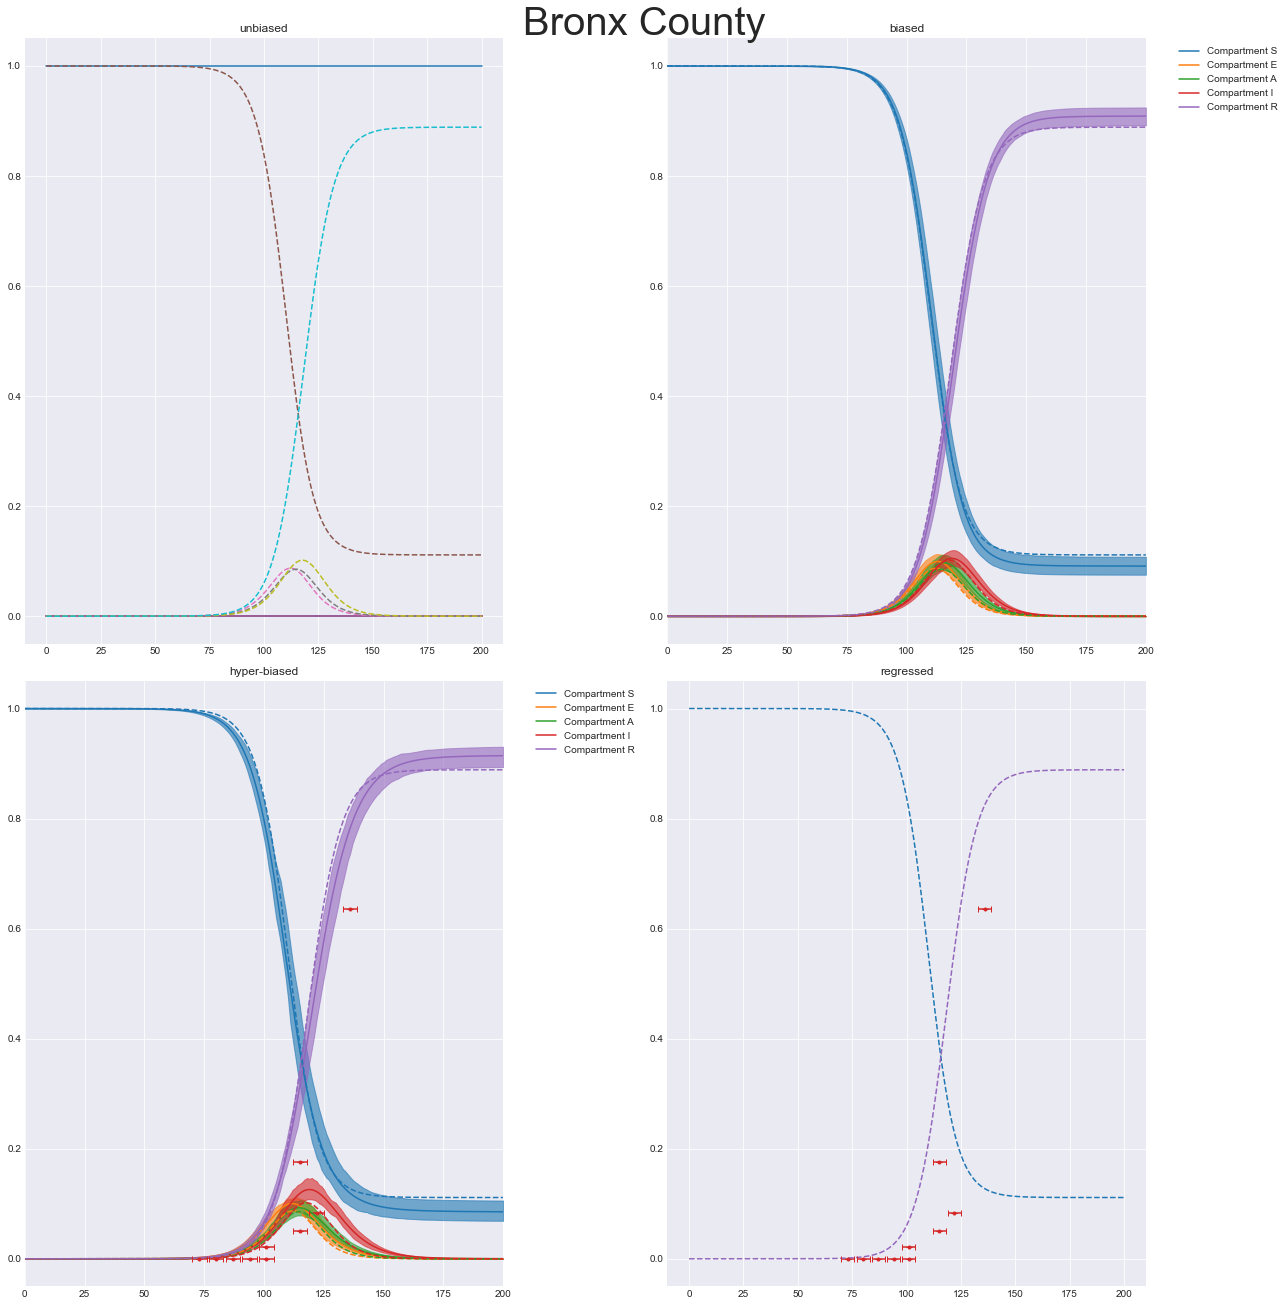

(1, 201, 62, 5)


In [122]:
patch_number = 2
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
axs[0,0].plot(trajs[0,:,patch_number,:])
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns_list[patch_number]):
#     pf(axs[0,0], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns_list[patch_number]):
#     pf(axs[0,1], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,1], 1, color='C3')

plt.tight_layout()
plt.savefig('compare_Livingston.png', dpi = 300)
plt.show()
print (ref_traj.shape)

In [123]:
weights_dict = {'unbiased':None, 'biased':me_model.traj_weights, 'hyper-biased':hme_model.traj_weights, 'regression':None }
from matplotlib.patches import Patch
print (restrained_patches)
def compare_patches(ref_traj,trajs,weights_dict, method ,*args, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
    weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.03)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.03)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[p,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
            if i * ncol + j in restrained_patches and method != 'unbiased':
                for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
                    pf(ax[i,j],0, color='C3')
                ax[i,j].spines['bottom'].set_color('y')
                ax[i,j].spines['top'].set_color('y') 
                ax[i,j].spines['right'].set_color('y')
                ax[i,j].spines['left'].set_color('y')
                ax[i,j].spines['left'].set_linewidth(2)
                ax[i,j].spines['top'].set_linewidth(2)
                ax[i,j].spines['right'].set_linewidth(2)
                ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
    plt.tight_layout()


[ 2 50 17]


Plotting 62 patches in a 7 x 9 grid


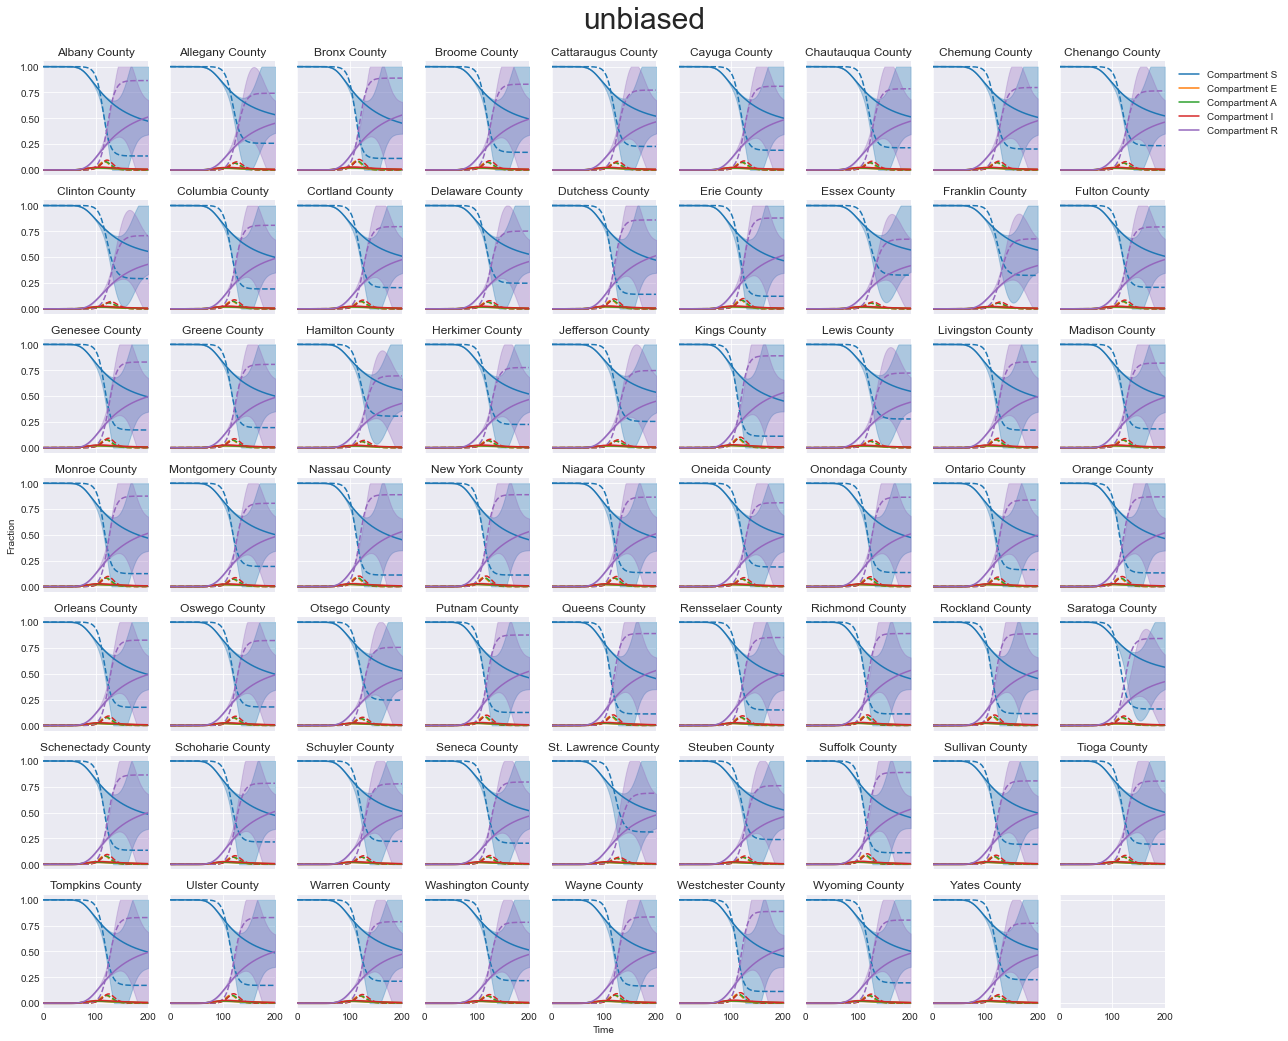

In [124]:
compare_patches(ref_traj,trajs,weights_dict,'unbiased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_unbiased.png',dpi=300)
# (ref_traj, trajs,weights_dict,'biased',patch_names = patches)

Plotting 62 patches in a 7 x 9 grid


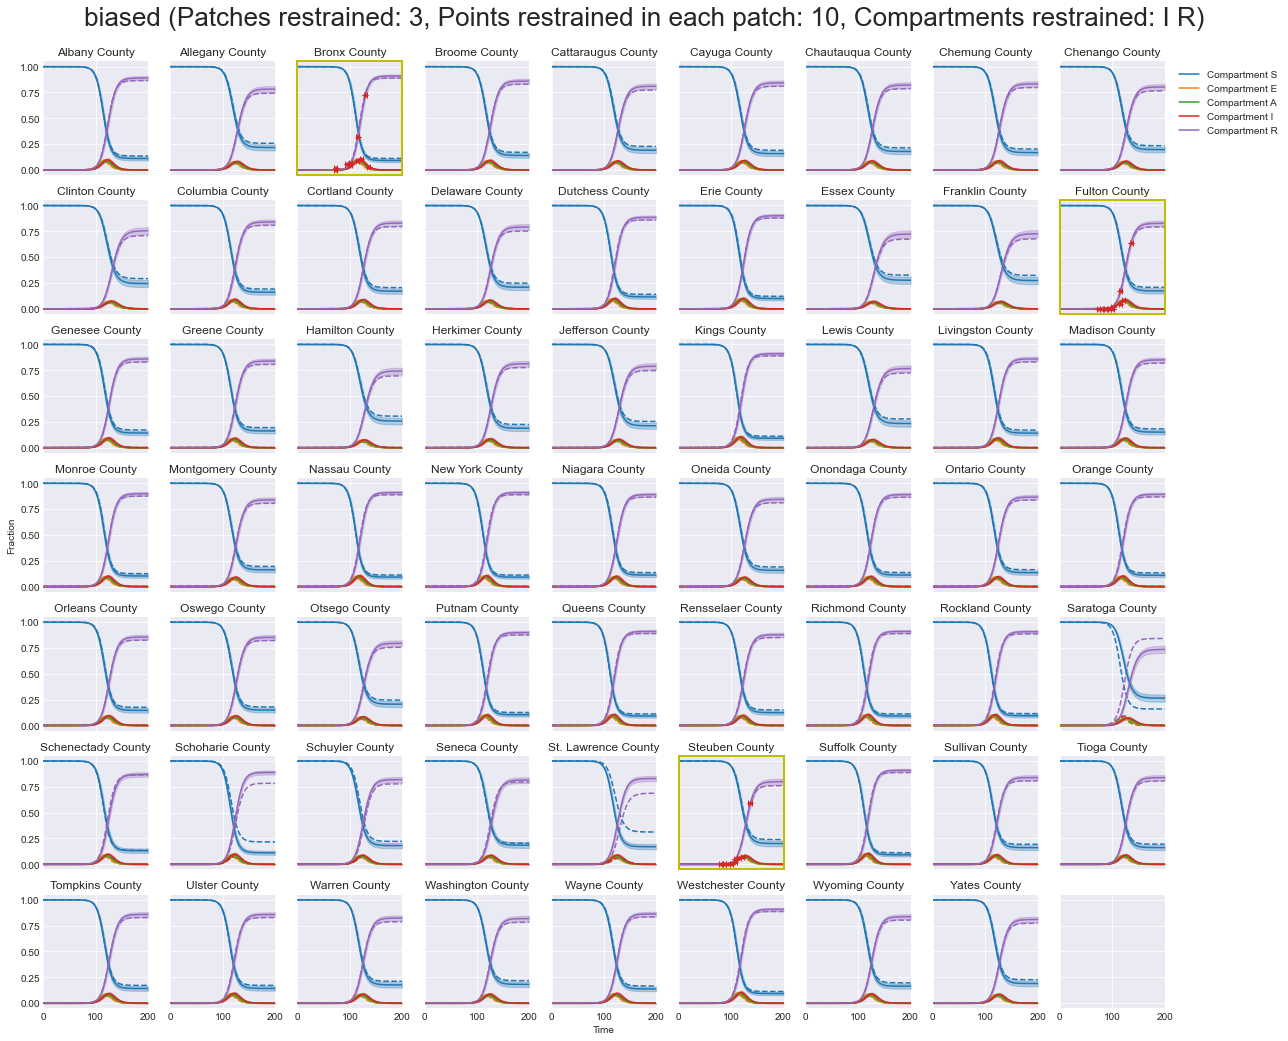

In [125]:
compare_patches(ref_traj,trajs,weights_dict,'biased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_biased_{}_restrained_{}.png'.format(len(restrained_patches),restrained_compartments_names),dpi=300)
# (ref_traj, trajs,weights_dict,'biased',patch_names = patches)

Plotting 62 patches in a 7 x 9 grid


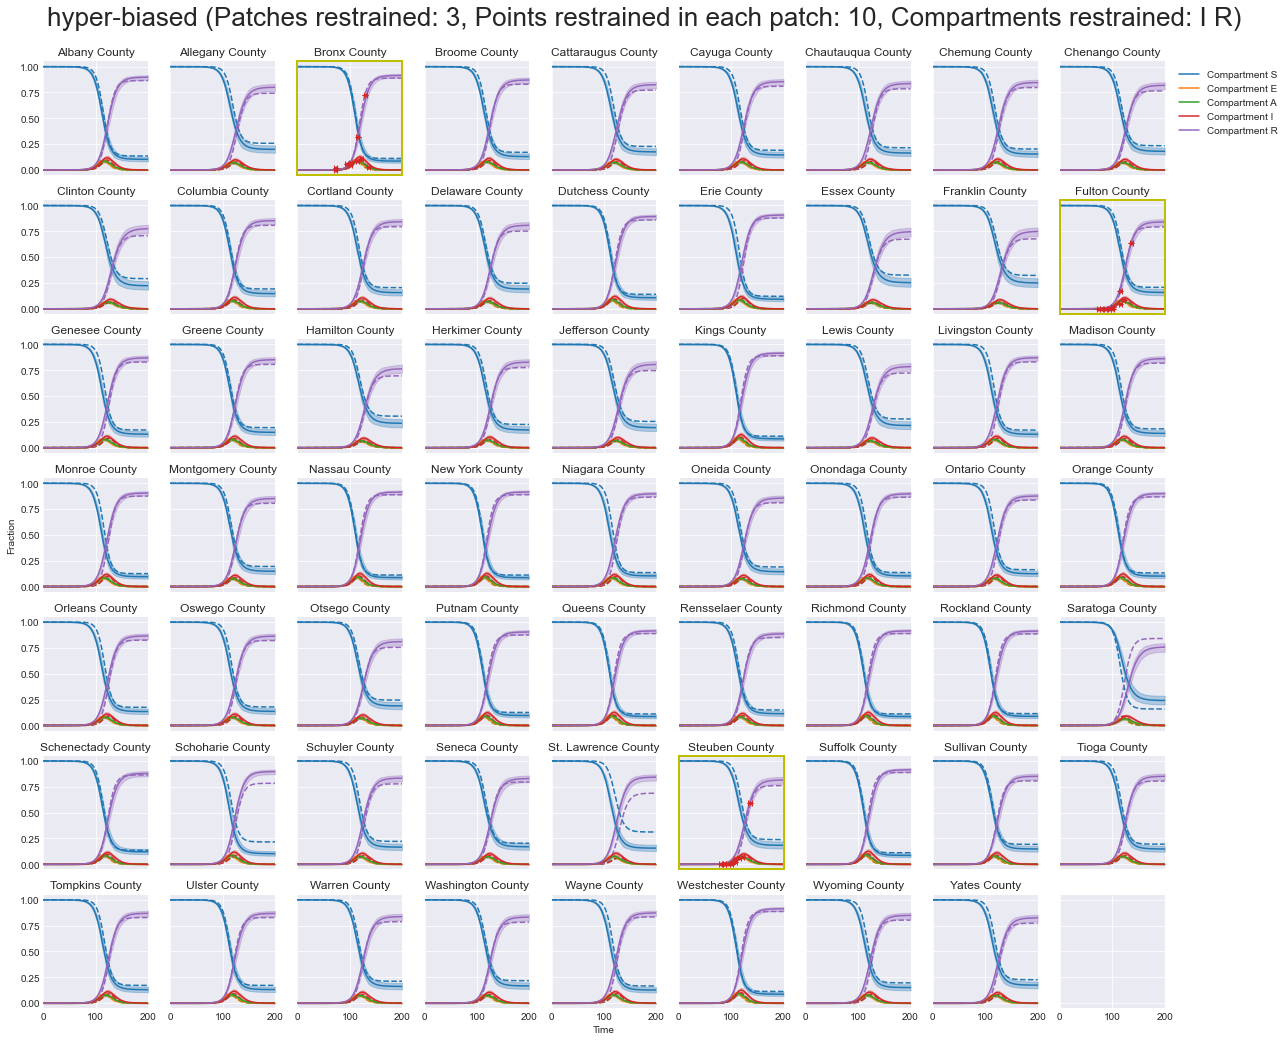

In [126]:
compare_patches(ref_traj,hme_model.trajs,weights_dict,'hyper-biased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_hyper_{}_restrained_{}.png'.format(len(restrained_patches),restrained_compartments_names),dpi=300)

In [127]:
weight_hyper = weights_dict['hyper-biased']
# weight_hyper /=np.sum(weight_hyper)
# mtrajs_patch = np.sum(trajs[:,:,0,:] * weight_hyper[:, np.newaxis, np.newaxis], axis=0)
# print (trajs.shape)
# print (mtrajs_patch.shape)
# print (trajs.shape[2], trajs.shape[-1])
def mean_traj(trajs,weights=None):
    Time = trajs.shape[1]
    c = trajs.shape[-1]
    M = trajs.shape[2]
    if weights is None:
        w = np.ones(trajs.shape[0])
    else:
        w = weights
    w /= np.sum(w)
    mtrajs_counties = np.empty([Time,M,c])
    for i in range(M):
        mtrajs_counties[:,i,:] = np.sum(trajs[:,:,i,:] * w[:, np.newaxis, np.newaxis], axis=0)
    mtrajs = np.sum(mtrajs_counties*population_fraction[np.newaxis, :, np.newaxis],axis=1)
    return mtrajs

    
mtrajs_hyper_biased = mean_traj(hme_model.trajs,weights = weights_dict['hyper-biased'])



mtrajs_biased = mean_traj(trajs,weights = weights_dict['biased'])
mtrajs_unbiased = mean_traj(trajs)
# REF = ref_traj[p,:,:,:]
# REF = np.expand_dims(REF,axis=0)
mref_traj = mean_traj(ref_traj)


mref_traj = mref_traj[:,:5]

loss_unbiased = np.mean((mref_traj- mtrajs_unbiased)**2)
loss_biased = np.mean((mref_traj- mtrajs_biased)**2)
loss_hyper_biased = np.mean((mref_traj- mtrajs_hyper_biased)**2)



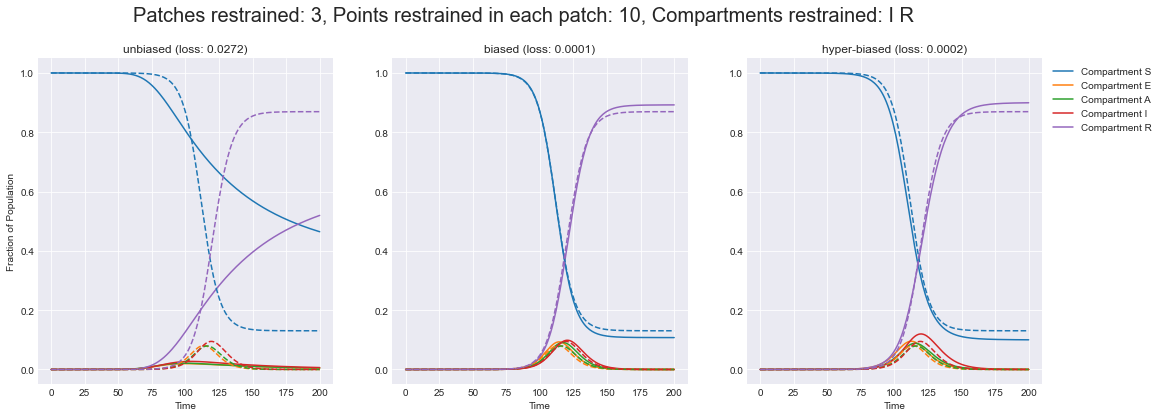

0.9999350536122869


In [128]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
fig.suptitle('Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {}'
             .format(len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names), fontsize=20,y=1.00)

axs[0].set_title('unbiased (loss: {})'.format(np.round(loss_unbiased,4)))
axs[1].set_title('biased (loss: {})'.format(np.round(loss_biased,4)))
axs[2].set_title('hyper-biased (loss: {})'.format(np.round(loss_hyper_biased,4)))
for i in range(mref_traj.shape[-1]):
    axs[0].plot(range(Time),mtrajs_unbiased[:,i],color=f'C{i}',label=f'Compartment {full_compartments[i]}')
    axs[1].plot(range(Time),mtrajs_biased[:,i],color=f'C{i}',label=f'Compartment {full_compartments[i]}')
    axs[2].plot(range(Time),mtrajs_hyper_biased[:,i],color=f'C{i}',label=f'Compartment {full_compartments[i]}')

axs[0].plot(mref_traj,linestyle='--')
axs[1].plot(mref_traj,linestyle='--')
axs[2].plot(mref_traj,linestyle='--')
axs[2].legend(bbox_to_anchor=(1.4, 1))
plt.setp(axs[:], xlabel='Time')
plt.setp(axs[0], ylabel='Fraction of Population')

# plt.tight_layout()
plt.savefig('compare_means_restraints_{}{}.png'.format(len(restrained_patches),restrained_compartments_names),dpi=300)
plt.show()
print (np.sum(mtrajs_biased[-1]))

In [129]:
Loss = np.mean((mref_traj- mtrajs_unbiased)**2)
print (Loss)

# print(end - start)

0.027212869408821838


Plotting 62 patches in a 7 x 9 grid


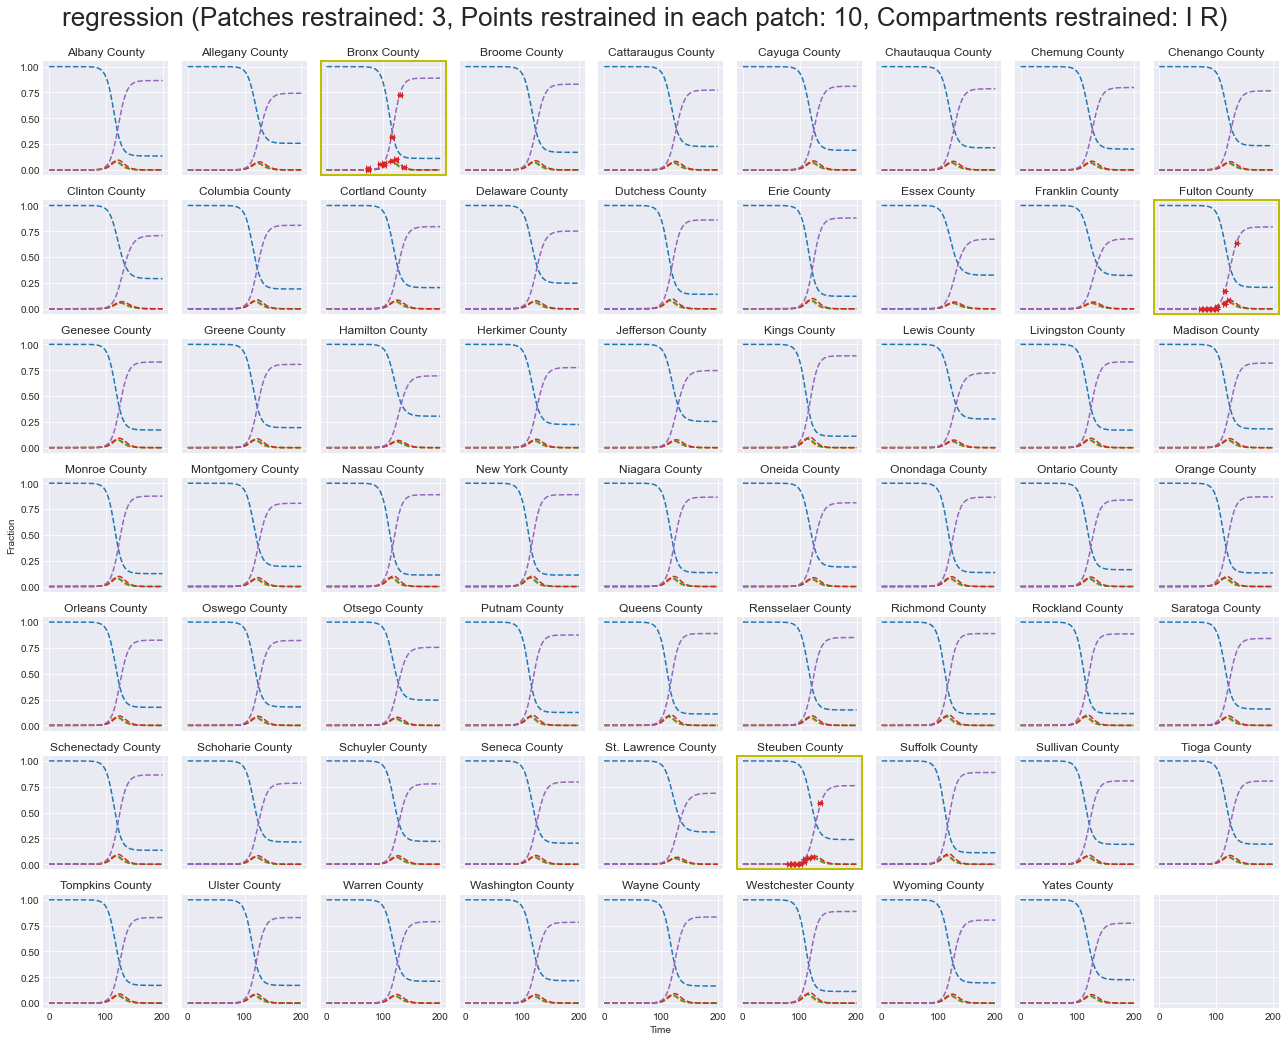

In [130]:
compare_patches(ref_traj,trajs,weights_dict,'regression', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_regression.png',dpi=300)


# Parameter posterior distributions

No handles with labels found to put in legend.


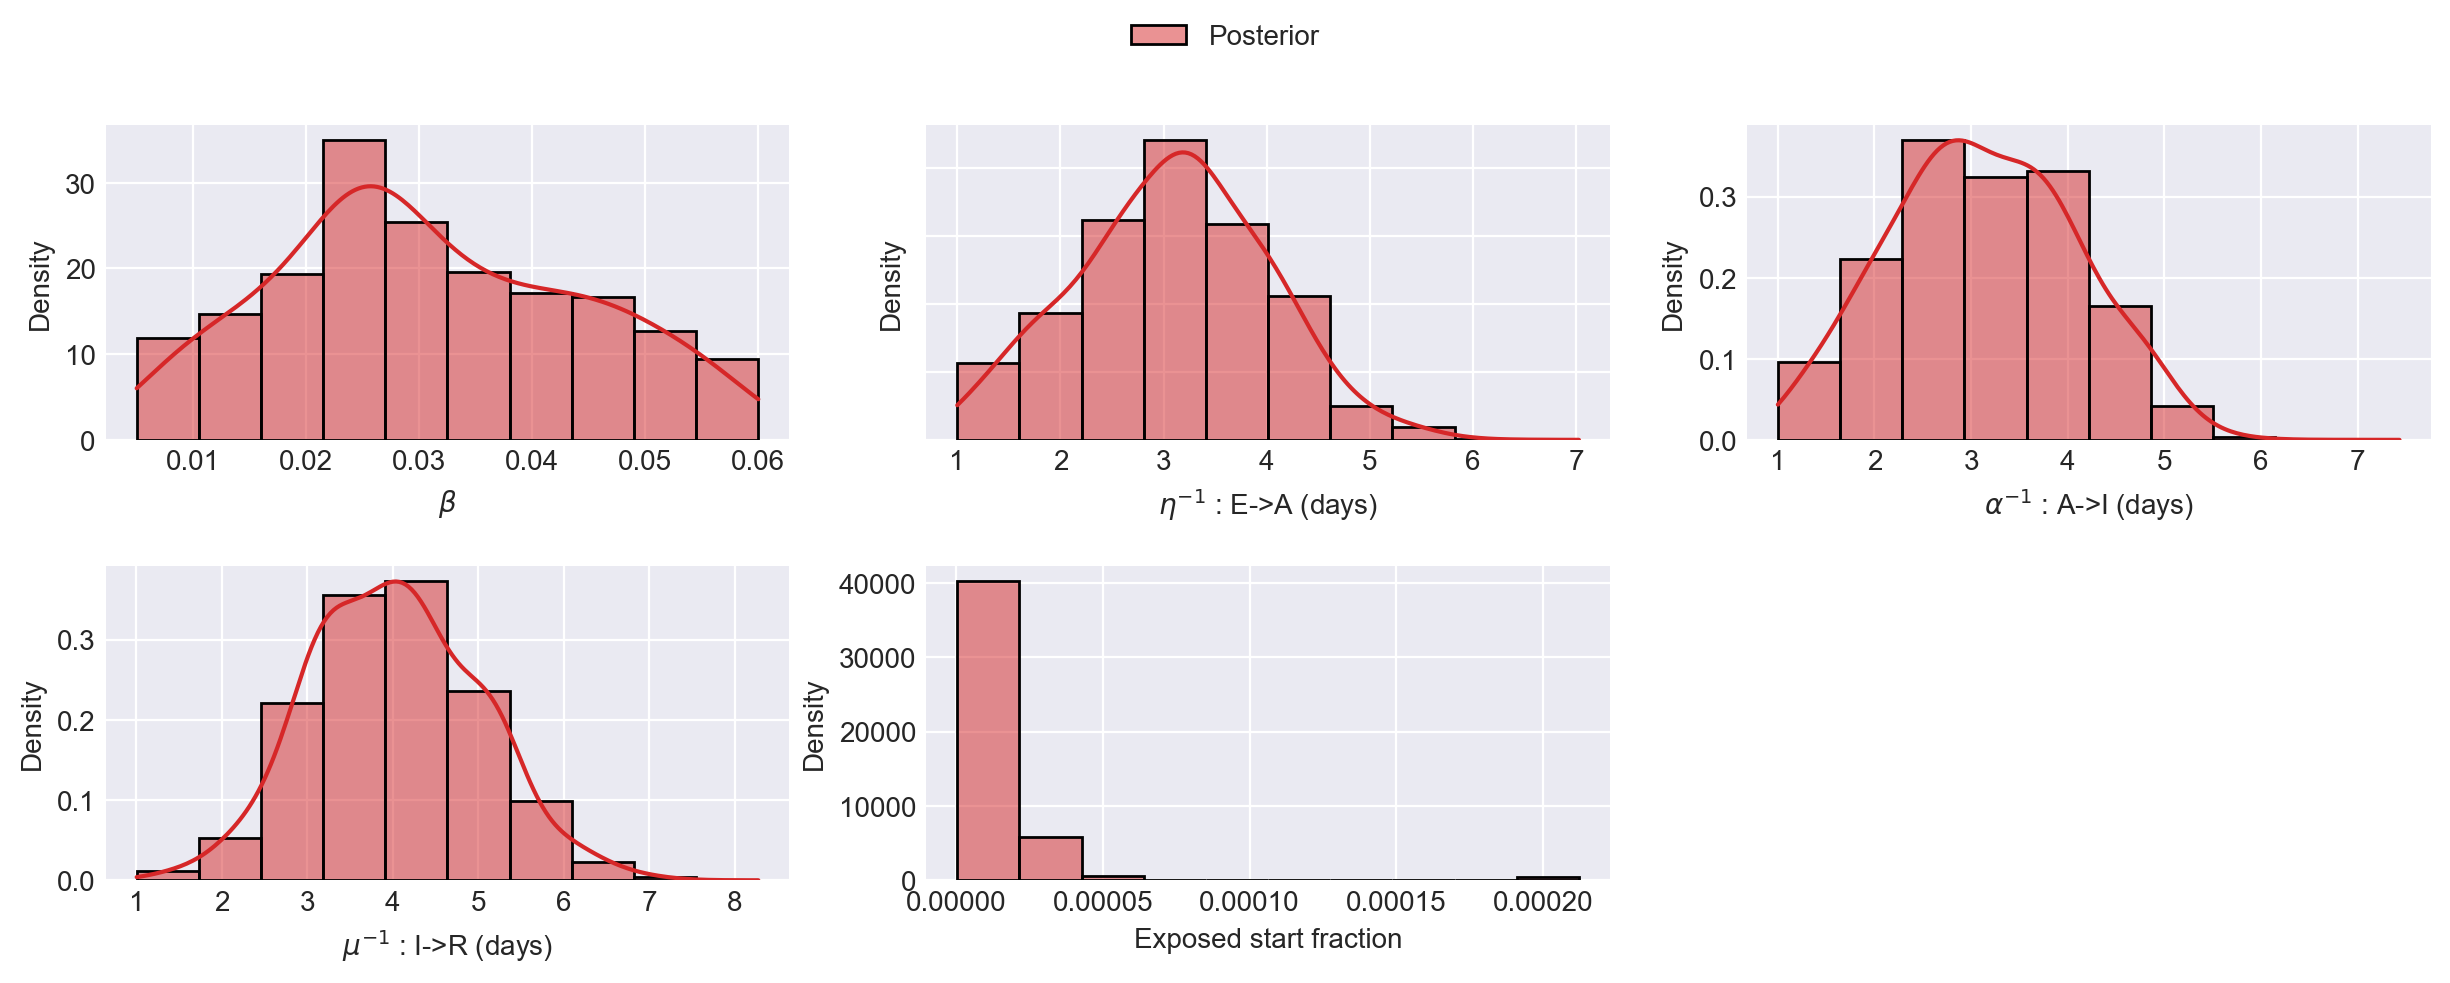

In [133]:

R_dist, E_A, A_I, I_R, start_exposed_dist, beta_dist = prior_param_dist
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,5), dpi=200)
sns.histplot(x=np.squeeze(beta_dist), weights=hme_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,0], kde=True, stat="density")
axs[0,0].set_xlabel(r'$\beta$')

sns.histplot(x=np.squeeze(E_A), weights=hme_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,1], kde=True, stat="density")
axs[0,1].set_xlabel(r'$\eta^{-1}$ : E->A (days)')

sns.histplot(x=np.squeeze(A_I), weights=hme_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,2], kde=True, stat="density")
axs[0,2].set_xlabel(r'$\alpha ^{-1}$ : A->I (days)')

sns.histplot(x=np.squeeze(I_R), weights=hme_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,0], kde=True, stat="density")
axs[1,0].set_xlabel(r'$\mu^{-1}$ : I->R (days)')

sns.histplot(x=np.squeeze(start_exposed_dist), weights=hme_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,1], kde=True, stat="density")
axs[1,1].set_xlabel('Exposed start fraction')


handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.subplots_adjust(hspace=0.4)
axs[-1, -1].axis('off')
axs[0,1].set_yticklabels('')
plt.legend()
# sns.displot(x=np.squeeze(beta_dist),stat="density", kde=True)

# Compare posterior with prior

No handles with labels found to put in legend.


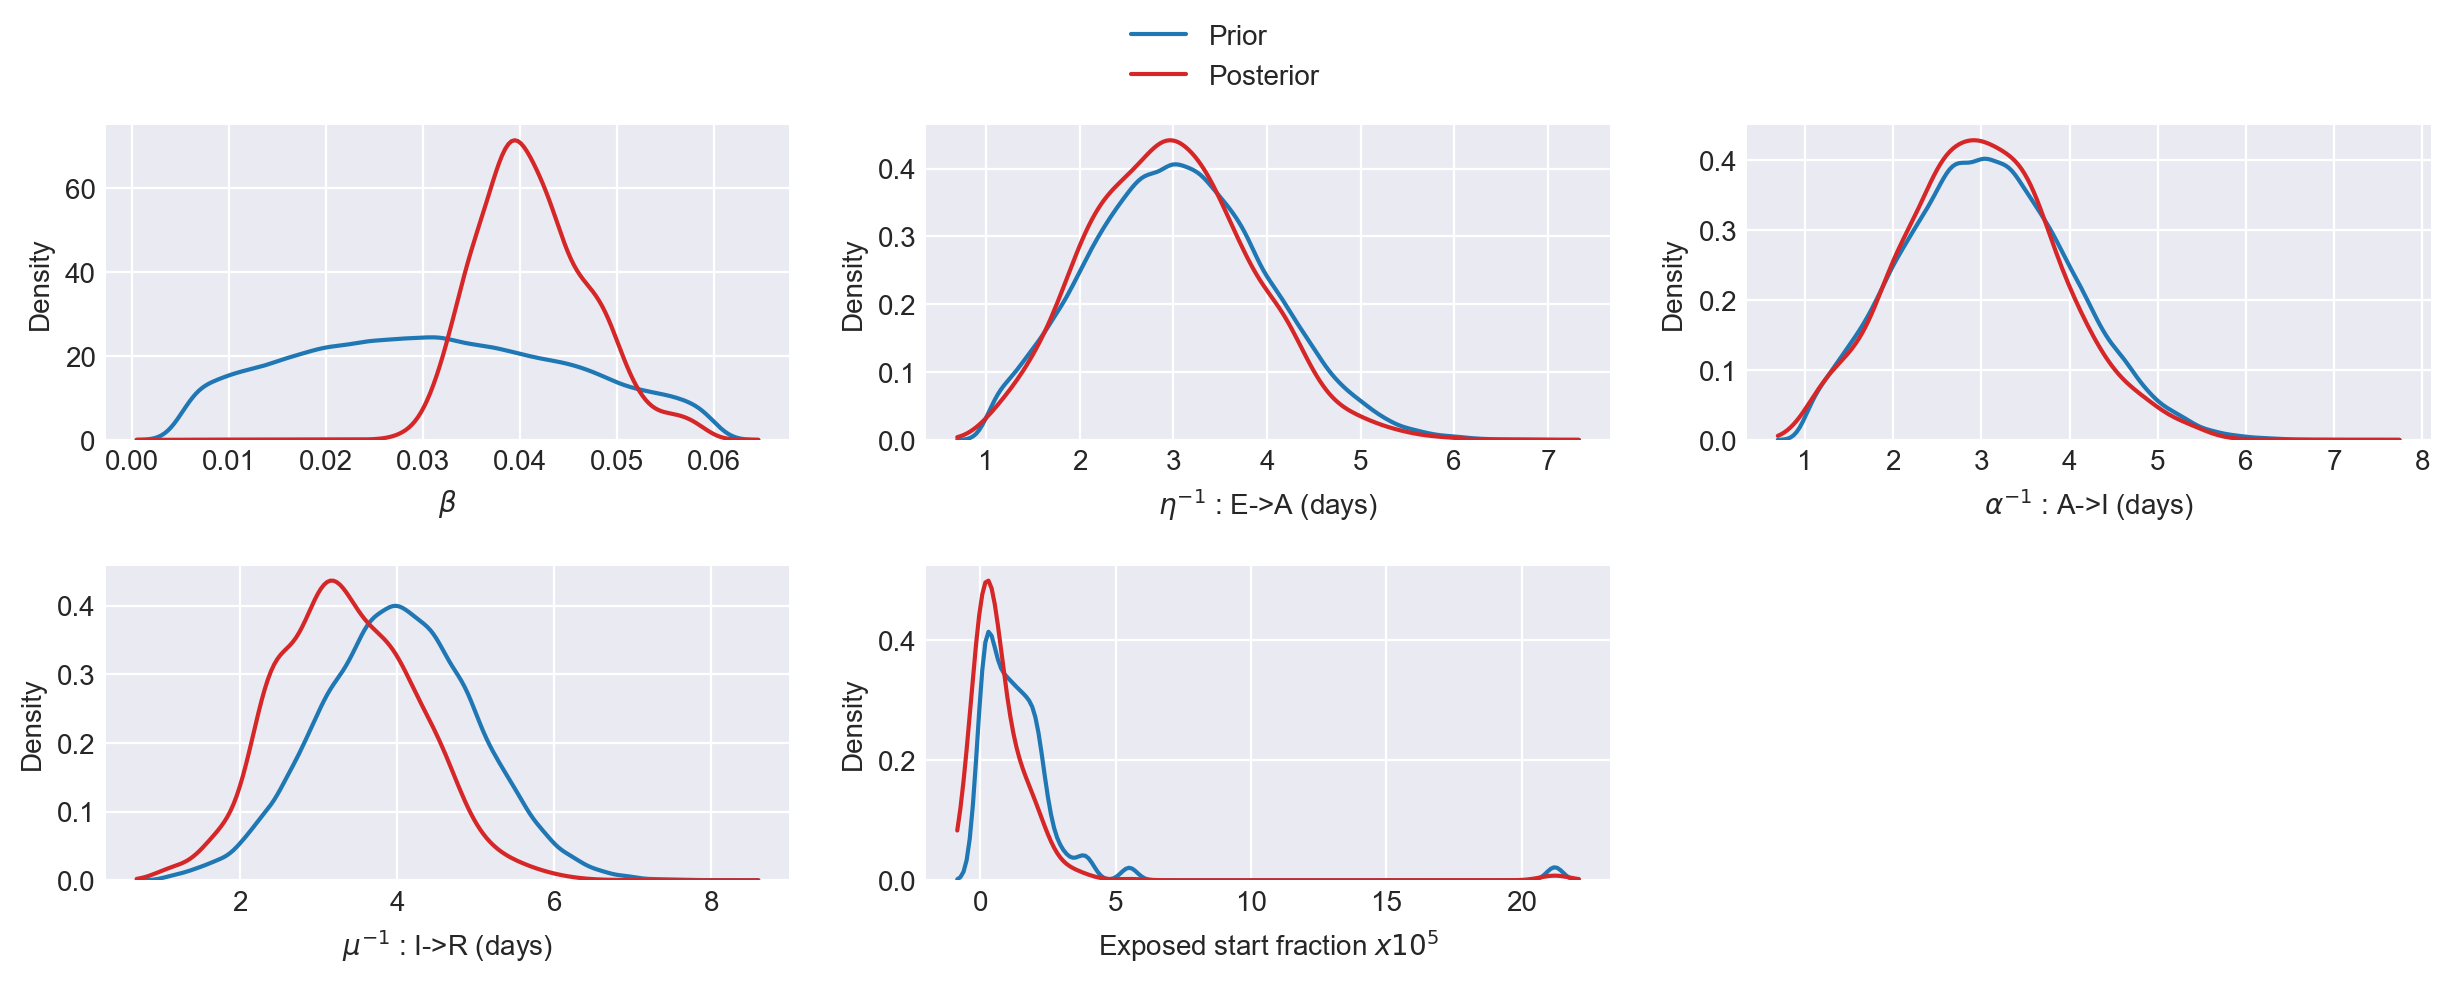

In [134]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,5), dpi=200)
sns.kdeplot(x=np.squeeze(beta_dist), label='Prior',
            color='C0', ax=axs[0,0])
sns.kdeplot(x=np.squeeze(beta_dist), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,0])
# sns.histplot(x=np.squeeze(beta_dist), weights=hme_model.traj_weights, label='Posterior',
#             color='C3', ax=axs[0,0], stat="density",kde=True)
axs[0,0].set_xlabel(r'$\beta$')
# sns.displot(x=np.squeeze(beta_dist),stat="density", kde=True)
sns.kdeplot(x=np.squeeze(E_A), label='Prior',
            color='C0', ax=axs[0,1])
sns.kdeplot(x=np.squeeze(E_A), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,1])
axs[0,1].set_xlabel(r'$\eta^{-1}$ : E->A (days)')

sns.kdeplot(x=np.squeeze(A_I), label='Prior',
            color='C0', ax=axs[0,2])
sns.kdeplot(x=np.squeeze(A_I), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,2])
axs[0,2].set_xlabel(r'$\alpha ^{-1}$ : A->I (days)')

sns.kdeplot(x=np.squeeze(I_R), label='Prior',
            color='C0', ax=axs[1,0])
sns.kdeplot(x=np.squeeze(I_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,0])
axs[1,0].set_xlabel(r'$\mu^{-1}$ : I->R (days)')

sns.kdeplot(x=np.squeeze(start_exposed_dist*1e5), label='Prior',
            color='C0', ax=axs[1,1])
sns.kdeplot(x=np.squeeze(start_exposed_dist*1e5), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,1])
axs[1,1].set_xlabel('Exposed start fraction $x10^5$')

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.subplots_adjust(hspace=0.4)
axs[-1, -1].axis('off')
plt.legend()
plt.savefig('compare_param_dist.png', dpi=300)

In [135]:
me_w = me_model.traj_weights
prior_exposed_patch = maxentep.exposed_finder(trajs)
posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)


In [ ]:
# maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability', fontsize=10, figsize=(10,8))
# maxentep.p0_map(prior_exposed_patch, M, weights = me_w, patch_names=patches, title = 'Posterior patient-zero probability', fontsize=10,figsize=(10,8))

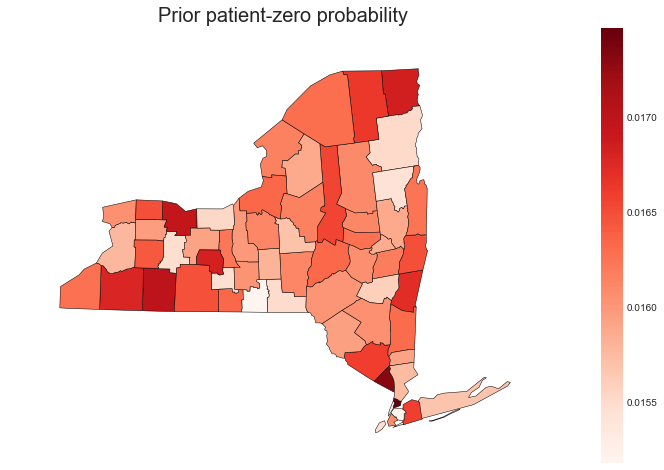

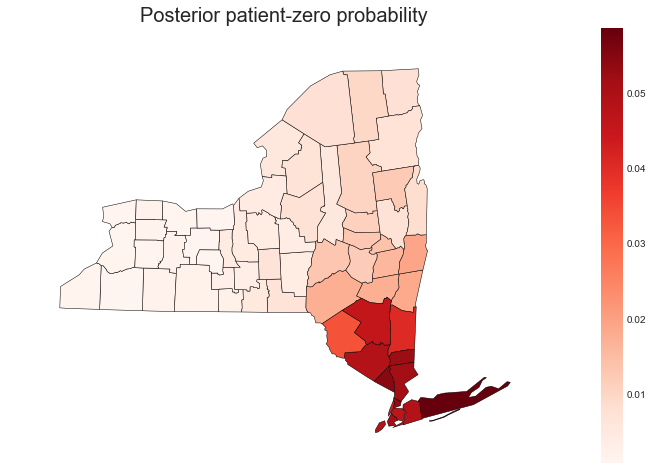

In [136]:
maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability', fontsize=20, choropleth=True,
       geojson='counties_ny.geojson')
maxentep.p0_map(prior_exposed_patch, M, weights = me_w, title = 'Posterior patient-zero probability', patch_names=patches, fontsize=20
      , choropleth=True, geojson='counties_ny.geojson')

Finding the top 5 most probable locations for the origin of outbreak:

In [137]:
sorted(zip(posterior_exposed_prob, patches), reverse=True)[:5]

[(0.0586937674645646, 'Suffolk County'),
 (0.05443641322962075, 'Rockland County'),
 (0.05340461499124991, 'Bronx County'),
 (0.05242298137268866, 'Putnam County'),
 (0.051602942947807824, 'Westchester County')]

## Theory 1
Basic reproductive number ($R_0$):

$ S \xrightarrow{\beta} E \xrightarrow{\eta} A \xrightarrow{\alpha} I \xrightarrow{\mu} R $

$R_0 = \frac{\beta S_0}{\alpha} +  \frac{\beta S_0}{\mu } $

$ t_{max} \sim \frac{log(S_0)}{\mu (R_0 -1)}$

In [138]:
total_pop = np.sum(population)
R0 = beta*total_pop*(1/alpha + 1/mu)

NameError: name 'beta' is not defined

In [ ]:
t_max = np.log(total_pop)/mu/(R0-1)

In [ ]:
t_max